# MCB - Block C (Bioinformatics) - Practical 2

## Part 1 - Progressive Multiple Sequence Alignment in Python

In this practical we will first explore building up from last weeks content towards building our own multiple sequence alignments (MSA) in Python.

We will extend our Needleman-Wunsch Global aligner to compute distances between proteins, place them in a distance matrix and use this to cluster the sequences using WPGMA into a guide tree for progressive, greedy alignment as we discussed in the lectures.

Our final MSA will be produced purely in python. As always, please ask if any of the python code is unclear.

## Load some modules

Lets get the main python modules loaded that we will need for later

In [5]:
!pip install plot-phylo
!pip install biopython

import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from io import StringIO
import math
import scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.4 MB/s  0:00:00


## Initial Housekeeping

Just like last time, we will build our *BLOSUM62* matrix first as a numpy array and then we'll use ASCII values to make a faster lookup table.

This is the same way we represented *BLOSUM62* last week and it will come in handy multiple times later.

In [3]:

# Define a list of all amino acids in an array:
amino_acids=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X']

# Make a new matrix (bmat) and populate with values obtained from BLOSUM62
bmat = np.matrix([[4,-1,-2,-2,0,-1,-1,0,-2,-1,-1,-1,-1,-2,-1,1,0,-3,-2,0,-2,-1,0],
[-1,5,0,-2,-3,1,0,-2,0,-3,-2,2,-1,-3,-2,-1,-1,-3,-2,-3,-1,0,-1],
[-2,0,6,1,-3,0,0,0,1,-3,-3,0,-2,-3,-2,1,0,-4,-2,-3,3,0,-1],
[-2,-2,1,6,-3,0,2,-1,-1,-3,-4,-1,-3,-3,-1,0,-1,-4,-3,-3,4,1,-1],
[0,-3,-3,-3,9,-3,-4,-3,-3,-1,-1,-3,-1,-2,-3,-1,-1,-2,-2,-1,-3,-3,-2],
[-1,1,0,0,-3,5,2,-2,0,-3,-2,1,0,-3,-1,0,-1,-2,-1,-2,0,3,-1],
[-1,0,0,2,-4,2,5,-2,0,-3,-3,1,-2,-3,-1,0,-1,-3,-2,-2,1,4,-1],
[0,-2,0,-1,-3,-2,-2,6,-2,-4,-4,-2,-3,-3,-2,0,-2,-2,-3,-3,-1,-2,-1],
[-2,0,1,-1,-3,0,0,-2,8,-3,-3,-1,-2,-1,-2,-1,-2,-2,2,-3,0,0,-1], 
[-1,-3,-3,-3,-1,-3,-3,-4,-3,4,2,-3,1,0,-3,-2,-1,-3,-1,3,-3,-3,-1],
[-1,-2,-3,-4,-1,-2,-3,-4,-3,2,4,-2,2,0,-3,-2,-1,-2,-1,1,-4,-3,-1],
[-1,2,0,-1,-3,1,1,-2,-1,-3,-2,5,-1,-3,-1,0,-1,-3,-2,-2,0,1,-1],
[-1,-1,-2,-3,-1,0,-2,-3,-2,1,2,-1,5,0,-2,-1,-1,-1,-1,1,-3,-1,-1],
[-2,-3,-3,-3,-2,-3,-3,-3,-1,0,0,-3,0,6,-4,-2,-2,1,3,-1,-3,-3,-1],
[-1,-2,-2,-1,-3,-1,-1,-2,-2,-3,-3,-1,-2,-4,7,-1,-1,-4,-3,-2,-2,-1,-2],
[1,-1,1,0,-1,0,0,0,-1,-2,-2,0,-1,-2,-1,4,1,-3,-2,-2,0,0,0], 
[0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,1,5,-2,-2,0,-1,-1,0],
[-3,-3,-4,-4,-2,-2,-3,-2,-2,-3,-2,-3,-1,1,-4,-3,-2,11,2,-3,-4,-3,-2],
[-2,-2,-2,-3,-2,-1,-2,-3,2,-1,-1,-2,-1,3,-3,-2,-2,2,7,-1,-3,-2,-1],
[0,-3,-3,-3,-1,-2,-2,-3,-3,3,1,-2,1,-1,-2,-2,0,-3,-1,4,-3,-2,-1],
[-2,-1,3,4,-3,0,1,-1,0,-3,-4,0,-3,-3,-2,0,-1,-4,-3,-3,4,1,-1],
[-1,0,0,1,-3,3,4,-2,0,-3,-3,1,-1,-3,-1,0,-1,-3,-2,-2,1,4,-1],
[0,-1,-1,-1,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-2,0,0,-2,-1,-1,-1,-1,-1]])


Lets turn this into an integer matrix indexed on the ASCII values of nucleotides, just like the last practical

The new matrix will be called *blosum_matrix*.

In [4]:

# Turn this object into a dataframe that can be accessed by amino-acid characters directy
blosum62 = pd.DataFrame(bmat, columns=amino_acids, index=amino_acids)

blosum_matrix = np.zeros(shape=(255, 255), dtype=int)  

# Populate the new object with values from the dataframe, we will rapidly lookup by using the integer value
# of each amino-acids ASCII value just like we did in the last practical
for row in blosum62.index.values:
    for col in blosum62.columns:
        blosum_matrix[ord(row),ord(col)]=blosum62[row][col]


## Code for performing the initial pairwise alignment - DP Needleman Wunsch

We need to work out which are the closest sequences so we can start a greedy progressive multiple alignment.

We will use the Needleman-Wunsch (affine gap) code from the end of last weeks practical to quick search pairs of sequences. This will be ready when we need it later.

For this NW is the best option as we are looking for global alignments.

We've made some modification to also compute the edit distance between pairs and not just their alignment score. Clustering (below) works better on distances rather than similarities.

This is the most complex Affine-Gap implementation with three matrices for scores (top, middle and bottom) and associated traceback pointers so that the score at any position in any matrix also has a pointer to which matrix that score came from.

We've also adapted this so it can compare sequences which have consensus patterns inside them.

In [6]:
# Needleman-Wunsch Alignment using Affine Gap Penalties.

def affine_align_nw(s1, s2):
    class Score(int): 
        GAPOPEN = -6 
        GAPEXTEND = -1

    # Our match score function is a little improved here to allow us to score sequence consensuses.
    def match_score(s1,s2):
        # We are building more capable aligner here we can either take a pair of sequences to align just as before
        # i.e. we could be passed 'L' and 'V' and simply look them up in BLOSUM and return the score.
        if(len(s1)==1 and len(s2)==1):
            return(blosum_matrix[ord(s1)][ord(s2)])
        else:
            # Or we can be passed two consensus sequences to align, in which case we will work out the average of 
            # the sum of pairs over all pairwise combinations like we described in the lectures on MSA.
            ntests=0
            tscore=0
            for z in range(0,len(s1)):
                for p in range (0,len(s2)):
                    ntests+=1
                    tscore+=blosum_matrix[ord(s1[z])][ord(s2[p])]
            tscore=tscore/ntests;
            return(tscore)
    
    NINF = float('-inf') # for setting the first row and column
    I = Score.GAPOPEN
    E = Score.GAPEXTEND
    
    fromM, fromX, fromY = 1, 2, 3   # Pointers to keep track of where the traceback is going (middle, upper, lower)

    l1 = len(s1)
    l2 = len(s2)

    M = [[(0, 0) for i in range(l2+1)] for j in range(l1+1)]  # Middle matrix
    X = [[(0, 0) for i in range(l2+1)] for j in range(l1+1)]  # Upper matrix
    Y = [[(0, 0) for i in range(l2+1)] for j in range(l1+1)]  # Lower matrix

    # Matrix initialisation
    for i in range(1, l1+1):
        M[i][0] = (NINF, 0)
        X[i][0] = (NINF, 0)
        Y[i][0] = (I + i * E, fromY)

    for i in range(1, l2+1):
        M[0][i] = (NINF, 0)
        X[0][i] = (I + i * E, fromX)
        Y[0][i] = (NINF, 0)

    # Dynamic Programming Recursion
    for i in range(1, l1+1):
        for j in range(1, l2+1):
            sub_score = match_score(s1[i - 1], s2[j - 1])
            # Recursion functions here 
            M[i][j] = max((M[i-1][j-1][0]+sub_score, fromM), (X[i-1][j-1][0]+sub_score, fromX), (Y[i-1][j-1][0]+sub_score, fromY))
            X[i][j] = max(
                    (I + E + M[i][j-1][0], fromM),
                    (E + X[i][j-1][0], fromX),
                    (I + E + Y[i][j-1][0], fromY))
            Y[i][j] = max(
                    (I + E + M[i-1][j][0], fromM),
                    (I + E + X[i-1][j][0], fromX),
                    (E + Y[i-1][j][0], fromY))


    # Empty alignment strings for the traceback routine
    aln1=[]
    aln2=[]

    # Start traceback from best matrix (highest score)
    if ((M[i][j][0] >= X[i][j][0]) and M[i][j][0] >= Y[i][j][0]):
        bestscore=M[i][j][0]
        current = M
    elif (X[i][j][0] > Y[i][j][0]):
        bestscore=X[i][j][0]
        current = X
    else:
        bestscore=Y[i][j][0]
        current = Y
    
    while (i > 0 or j > 0):
        if current == M:
            if current[i][j][1] == fromM:
                i -= 1
                j -= 1
                current = M
                aln1.append(s1[i])
                aln2.append(s2[j])

            elif current[i][j][1] == fromX:
                i -= 1
                j -= 1
                current = X
                aln1.append(s1[i])
                aln2.append(s2[j])

            elif current[i][j][1] == fromY:
                i -= 1
                j -= 1
                current = Y
                aln1.append(s1[i])
                aln2.append(s2[j])

        elif current == X:
            if current[i][j][1] == fromM:
                j -= 1
                current = M
                aln1.append('-')
                aln2.append(s2[j])

            elif current[i][j][1] == fromX:
                j -= 1
                current = X
                aln1.append('-')
                aln2.append(s2[j])

            elif current[i][j][1] == fromY:
                j -= 1
                current = Y
                aln1.append(s1[i])
                aln2.append('-')

        elif current == Y:
            if current[i][j][1] == fromM:
                i -= 1
                current = M
                aln1.append(s1[i])
                aln2.append('-')

            elif current[i][j][1] == fromX:
                i -= 1
                current = X
                aln1.append('-')
                aln2.append(s2[j])
            elif current[i][j][1] == fromY:
                i -= 1
                current = Y
                aln1.append(s1[i])
                aln2.append('-')

    # Reverse the alignment as we traceback in reverse.
    aln1.reverse()
    aln2.reverse()

    # Now we want to take the sequence alignment that had the best score and turn it into a distance.
    distance=0
    
    # Simple function to look at the alignment and compute a Hamming distance on non-gap regions
    # First we compute the number of exact matches
    for i in range(0,len(aln1)):
        if ((aln1[i] != '-') & (aln2[i] != '-')):
            if (aln1[i] == aln2[i]):
                distance=distance+1

    # The distance is 1.0 - the fraction of exact matching characters ignoring gaps.
    distance=1-(distance/len(aln1))

    # return the optimal alignment strings, the score and importantly now a distance
    return (aln1,aln2,bestscore,distance)


# Building our own Multiple Sequence Aligner


## Performing the pairwise sequence scan

We will load some *Globin* gene sequences (shortened versions for this test). Later on we will explore the full family.

This time we will declare our matrices in advance and reuse them to save time.

We use **BioPython** to load a fasta file *globin_small.fasta* which contains 10 sequences. 

We will compare every sequence against every other, but there's no point comparing AvsB and then BvsA as the score would be the same. There's also no point comparing AvsA as we know it will be identical. So we cut the number of comparisons down to ((n-1) x n)/2 or a total of 45 comparisons.

We want to work out both the alignment score **and** the edit distance. We will store the distances in a new matrix called *wpgma_matrix* which we will used to cluster the sequences with *WPGMA*.

This clustering will guide our greedy progressive pairwise alignment.

In [8]:
# Lets read in sequences from our FASTA file

# First prepare some variables
i=0            # counter for how many sequences we find
sequences=[]   # array for sequences
names=[]       # array for the sequence identifiers from the FASTA file
orig_names=[]  # array to preserve the original names of each sequence as we may be merging things later


# Now Read in FASTA file, iterate our counter and store the sequence and the identifier for each
# We use BioPython for this (SeqIO)
print("Processing: ",end="")
for record in SeqIO.parse("data/L2/globin_small.fasta", "fasta"):
    this_seq=[char for char in record.seq]
    sequences.append(this_seq)
    names.append(record.name)
    orig_names.append(record.name)
print(len(sequences),"Sequences Loaded\n")


# For WPGMA clustering we need a Distance matrix, lets make it now 
# We need to compare all sequences against each other.
#
# First an empty numpy matrix to store the distances.
wpgma_matrix = np.zeros(shape=(len(sequences), len(sequences)), dtype=float) 

# Now for each of our sequences we will compare it to all the other ones
# The matrix is symmetric so we do not need to search all combinations, just half the matrix
#
# We store in the WPGMA matrix a normalised distance computed from the edit distance divided by the aln length

# We never want to pick the diagonals as having the smallest distance, so set these to infinity
for i in range(0,len(sequences)):
    wpgma_matrix[i][i]=np.inf

# Now iterate through the matrix and compute the distance between each sequence to the others
for i in range(0,len(sequences)-1):
    print("Aligning Sequence " + str(i) +" vs the Rest ")
    for j in range(i+1,len(sequences)):
        # populate our distance matrix with the distance obtained from our global alignment
        [aln1, aln2, score, distance] = affine_align_nw(sequences[i], sequences[j])  
        wpgma_matrix[j][i]=distance
        wpgma_matrix[i][j]=distance

print("\nFinished") 



Processing: 10 Sequences Loaded

Aligning Sequence 0 vs the Rest 
Aligning Sequence 1 vs the Rest 
Aligning Sequence 2 vs the Rest 
Aligning Sequence 3 vs the Rest 
Aligning Sequence 4 vs the Rest 
Aligning Sequence 5 vs the Rest 
Aligning Sequence 6 vs the Rest 
Aligning Sequence 7 vs the Rest 
Aligning Sequence 8 vs the Rest 

Finished


## First-Pass Analysis

Lets explore the distance matrix we produced for each sequence versus the others. This is our main starting point for WPGMA clustering.

The closest pair of sequences should have the smallest normalised distance.

### Why compute distance matrix and not a similarity matrix (e.g. alignment score or % identity) ?

Well we want to build a tree later, and that works much better with normalised distances. The distances we produce are scaled from 0 (identical) to 1.0 (completely and totally different). We only compare the alignment at non-gap positions.
This allows better tree construction later. We could also do WPGMA on raw scores or on \% identity values, we'd just need to change the WPGMA from finding the minimum distance to finding the maximum score each time, but distances are far more appropriate for this task.

$$
S_{aln} = \frac{exact\_matches}{positions\_scored}     
$$

$$
D_{aln} = 1-S
$$

One could also do a Kimura type correction here, this is mentioned in the lecture notes, but usually better for nucleotides. This is the one for protein distance correction.

$$
D_{kimura} = -log_e( 1 - (D - 0.2*D^2)))
$$





## Our Distance Matrix

Lets take a look at the distances we computed from the first pass of pairwise alignments.

In [9]:
wpgma_matrix
pd.options.display.max_columns = None
pd.options.display.max_rows = None

wpgma_df = pd.DataFrame(wpgma_matrix, 
                      index=[names], 
                      columns=[names])
wpgma_df

,lgb1_pea,lgb1_vicfa,myg_escgi,myg_horse,myg_progu,myg_saisc,myg_lycpi,myg_mouse,myg_musan,hba_ailme
lgb1_pea,inf,0.268293,0.750000,0.844444,0.727273,0.727273,0.837209,0.727273,0.744186,0.863636
lgb1_vicfa,0.268293,inf,0.822222,0.822222,0.755556,0.727273,0.886364,0.777778,0.795455,0.837209
myg_escgi,0.750000,0.822222,inf,0.219512,0.219512,0.219512,0.243902,0.243902,0.609756,0.682927
myg_horse,0.844444,0.822222,0.219512,inf,0.121951,0.146341,0.170732,0.146341,0.634146,0.707317
myg_progu,0.727273,0.755556,0.219512,0.121951,inf,0.146341,0.146341,0.121951,0.609756,0.682927
myg_saisc,0.727273,0.727273,0.219512,0.146341,0.146341,inf,0.195122,0.170732,0.682927,0.731707
myg_lycpi,0.837209,0.886364,0.243902,0.170732,0.146341,0.195122,inf,0.121951,0.634146,0.688889
myg_mouse,0.727273,0.777778,0.243902,0.146341,0.121951,0.170732,0.121951,inf,0.634146,0.731707
myg_musan,0.744186,0.795455,0.609756,0.634146,0.609756,0.682927,0.634146,0.634146,inf,0.780488
hba_ailme,0.863636,0.837209,0.682927,0.707317,0.682927,0.731707,0.688889,0.731707,0.780488,inf


### Some visualisations

We can see a raw version of our distance matrix below using *Seaborn*

We can also compute a clustered correlation matrix as a quick initial clustering for visualisation purposes.

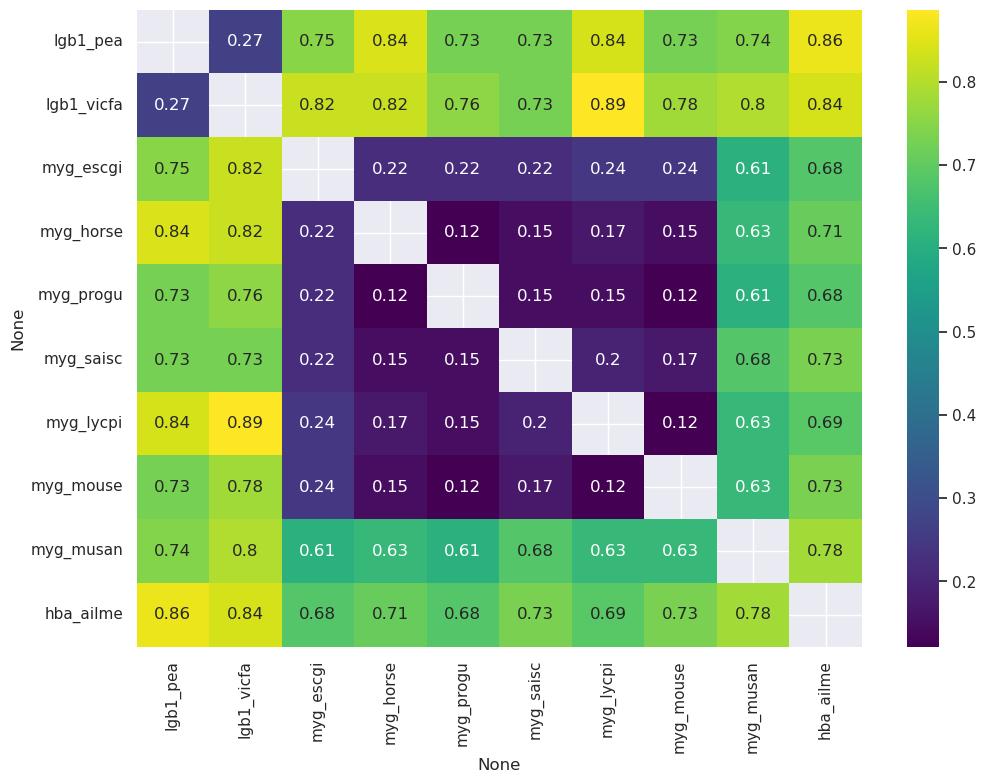

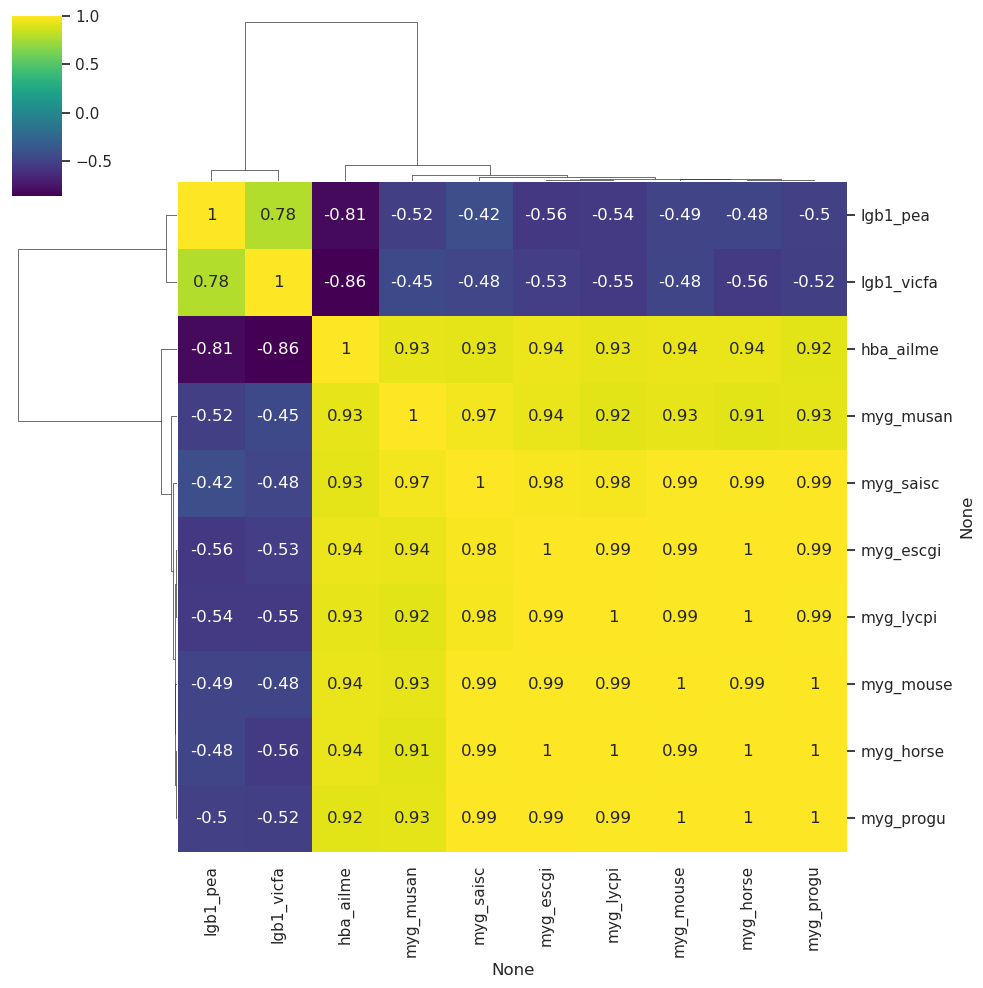

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Visualise the distance matrix of all sequences versus each other
# Use mask to hide the inf values on the diagonal so they don't break the color scale
sns.heatmap(wpgma_df, annot=True, cmap="viridis", mask=np.isinf(wpgma_df))


# Lets do a simple correlation clustering and look at that too.
# It should be similar to our WPGMA clustering later.
sns.clustermap(wpgma_df.corr(), annot=True, cmap="viridis");

It should be fairly obvious that we have a block of 8 quite closely related globins and two outliers. 


# Progressive Alignment using Clustering

## Overview of WPGMA and greedy alignment

Here's a version of the *WPGMA* algorithm we can use to cluster the distance matrix and find the closest pairs of sequences. We will also try and construct a simple phylogenetic tree and align sequences to consensus sequences as we go along.

We use the tree to guide the progressive pairwise alignment of our sequences and consensus sequences.

We will likely start with what appear to be the closest pair of sequences *myg_progu* and *myg_horse*

To build a multiple sequence alignment we will align sequences in a greedy manner and each time we make a new consensus sequence to realign to the next closest sequence (e.g. *myg_horse*).

Our Needleman-Wunsch above can handle both normal strings and also consensus strings.

In [12]:
# An algorithm for incrementally clustering a distance matrix by merging rows and columns via averaging
# Always merge the closest two, but ignore self matches.
# our matrix will become progressively smaller until we are fully clustered.


def wpgma_cluster(matrix,ids,seqs):

    for i in range(0,len(matrix)):
        # Lets set the self matches in the matrix to positive infinity, as it would confuse our code
        # which searches for the closest pair, we don't want to merge sequences to themselves!
        matrix[i][i]=np.inf

    # Keep searching for the closest pair of sequences
    # When we find the lowest value (closest pair), we average their rows and columns and then delete
    # one row and one column at each merge.
    # Hence our matrix gets smaller as nodes are merged.
    # While doing this we merge their names into a tree format.

    # Create a dictionary to store branch-lengths when we merge sequences according to distance
    # Allows us to make a proper tree later
    branch_lengths = {}
    for id in ids:
        branch_lengths[id]=0.0

    
    # while the matrix has more than 1 entry, we will reduce it by 1 row and col each time until nothing left
    
    while(len(matrix)>1):
        
        # Find the index (i,j) of the smallest value between different i and js
        ind = np.unravel_index(np.argmin(matrix, axis=None), matrix.shape)
        
        # Align the current two sequences or consensuses
        [a1, a2, a_s, a_d] = affine_align_nw(seqs[ind[0]], seqs[ind[1]])

        # Make a consensus sequence to represent the merged a1 and a2
        consensus=make_consensus(a1,a2)

        seq_id1=ids[ind[0]]
        seq_id2=ids[ind[1]]
        merge_distance=matrix[ind[0]][ind[1]]
        branch_length=round((matrix[ind[0]][ind[1]]/2),4)
 
        print("Merging Nodes: "+str(ind[0])+" and "+str(ind[1])+" Distance:" + 
              str(merge_distance) + " Branch Length:" + str(branch_length))

        # Merge their names into our tree format:
        # For newick tree format we have to subtract the previous branch length
        strmerge="(" + seq_id1 + ":" + str(round(branch_length-branch_lengths[ids[ind[0]]],4)) +","
        strmerge=strmerge + seq_id2 + ":" + str(round(branch_length-branch_lengths[ids[ind[1]]],4)) + ")"
        branch_lengths[strmerge]=branch_length

        # Fetch the two corresponding matrix columns
        x1=matrix[:,ind[0]:ind[0]+1]
        x2=matrix[:,ind[1]:ind[1]+1]
        # Average them
        avg=(x1+x2)/2
        # Replace one with the new average
        matrix[:,ind[0]:ind[0]+1]=avg
        
        # Fetch the two corresponding matrix rows
        y1=matrix[ind[0]:ind[0]+1:,]
        y2=matrix[ind[1]:ind[1]+1:,]
        # Average them
        avg=(y1+y2)/2
        # Replace them with the new average
        matrix[ind[0]:ind[0]+1:,]=avg
        
        # set the merged intersection to a distance of 1
        matrix[ind[0]][ind[0]]=np.inf

        # Delete one row and one of the columns, we already kept the merged values
        matrix = np.delete(matrix, ind[1], 0)
        matrix = np.delete(matrix, ind[1], 1)
        
        # Replace the original sequence with the merged consensus (above)
        # remove the redundant sequence
        seqs[ind[0]]=consensus
        seqs.pop(ind[1])

        # Replace one ID with the merged new ID
        ids[ind[0]]= strmerge
        # Delete one ID using 'pop' to reduce the identifiers
        ids.pop(ind[1])
        
    # We are done, return the final merged tree
    return(ids,consensus)


# Function to merge the results of an alignment into a single unified consensus sequence to replace the two
# we just merged. This will be realigned each time.
def make_consensus(s1,s2):

    # We need to resolve gaps as they don't expand properly from the consensus sequences like others do
    ll=len(max(s1,key=len))
    for i in range(0,len(s1)):
        if(s1[i]=="-"):
            s1[i]='-' * ll
    ll=len(max(s2,key=len))
    for i in range(0,len(s2)):
        if(s2[i]=="-"):
            s2[i]='-' * ll
    # Build a consensus array across the alignment pair
    cons=[]
    for i in range(0,len(s1)):
        cons.append(s1[i]+s2[i])
    return(cons)

Now we are ready to run our WPGMA clustering algorithm on our distance matrix *wpgma_matrix*

Our Numpy objects *wpgma_matrix* and *names* list be modified during this process. We want to avoid our master variables getting mangled, so we will send a copy of them instead of references by using *.copy()*


In [13]:
# Time to run our WPGMA

consensus=[]
[my_tree,consensus]=wpgma_cluster(wpgma_matrix.copy(),names.copy(),sequences.copy())


Merging Nodes: 3 and 4 Distance:0.12195121951219512 Branch Length:0.061
Merging Nodes: 5 and 6 Distance:0.12195121951219512 Branch Length:0.061
Merging Nodes: 3 and 4 Distance:0.14634146341463417 Branch Length:0.0732
Merging Nodes: 3 and 4 Distance:0.16463414634146342 Branch Length:0.0823
Merging Nodes: 2 and 3 Distance:0.23170731707317072 Branch Length:0.1159
Merging Nodes: 0 and 1 Distance:0.2682926829268293 Branch Length:0.1341
Merging Nodes: 1 and 2 Distance:0.6265243902439024 Branch Length:0.3133
Merging Nodes: 1 and 2 Distance:0.738939701897019 Branch Length:0.3695
Merging Nodes: 0 and 1 Distance:0.813710322703782 Branch Length:0.4069


## Some playing

Try modifying the WPGMA code above to print out the distance matrix after each merging.
You should see it getting smaller as the greedy algorithm works.

There are also probably ways to make this code faster and a little more efficient.

## The final result 
### A Newick Tree String
We have merged the identifiers of WPGMA merged sequences in a very particular format called NEWICK.

```
(myg_lycpi:0.00148720999405116,myg_mouse:0.00148720999405116):0.0005205234979179065):0.0008179654967281373):0.004814842355740631,myg_musan:0.007640541344437835):0.0012034108035608535):0.0005257017657136313,hba_ailme:0.00936965391371232)']
```

Newicks's is a [restaurant in Dover, New Hampshire, USA](http://newicks.com/) where the first meeting about defining a standard textual definition of a phylogenetic was agreed.

Nodes are joined in the tree into new nodes as follows:

A new node representing **A** joined to **B** is represented as (A,B:d)
**d** in this case is the distance at which the merge took place

This allows the tree to have branch lengths modelled.

In [14]:

print("\n",my_tree,"\n")



 ['((lgb1_pea:0.1341,lgb1_vicfa:0.1341):0.2728,(((myg_escgi:0.1159,(((myg_horse:0.061,myg_progu:0.061):0.0122,myg_saisc:0.0732):0.0091,(myg_lycpi:0.061,myg_mouse:0.061):0.0213):0.0336):0.1974,myg_musan:0.3133):0.0562,hba_ailme:0.3695):0.0374)'] 



### BioPython Phylogeny

As our tree is Newick format we can use BioPython to produce a phylogenetic tree.

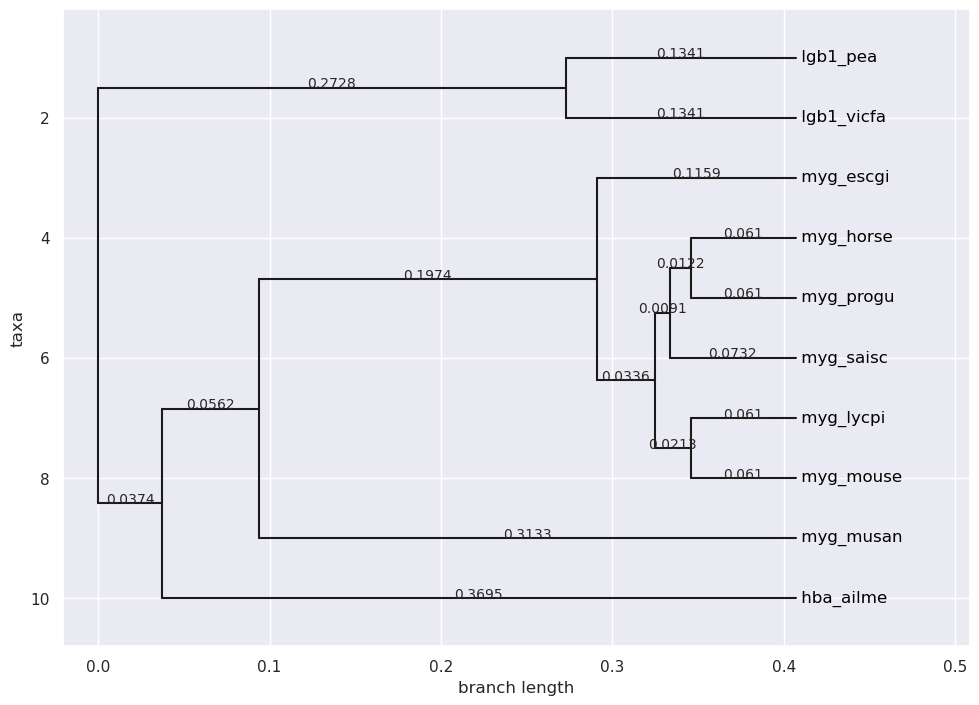

In [15]:
# Load some BioPython tools for tree drawing from Newick format
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# This prefers reading from files, so we will make a fake filehandle using StringIO
handle = StringIO(my_tree[0])

# Load our tree from a string pretending to be a file
tree = Phylo.read(handle, "newick")

# Draw the tree with labels for branch lengths estimated from our WPGMA
Phylo.draw(tree,branch_labels=lambda c: c.branch_length)




## A Multiple Sequence Alignment!

As we merged nodes via WPGMA, we also aligned the sequences to a consensus and then realigned these to each other in a greedy fashion.

The final string *consensus* contained the final merged alignment string. 

We will then use a Sum of all Pairs approach and then average the results, as described in the lectures. 

So if we are comparing **\[AT\]** with **\[A\]** we would take the match scores for A:A and A:T and average them and use this in the recursion function. This will all be done in the matching function.

if we were trying to align **\[ATA\]** with **\[CGG\]** we would compare:
```
A vs C
A vs G  
A vs G
T vs C
T vs G
T vs G
A vs C
A vs G
A vs G
```

and average the *BLOSUM62* scores obtained to return a match/mismatch score for **\[ATA\]** vs **\[CGG\]** as we pass through the alignment.

The wonderful thing about python is that we can pass our Needlman-Wunsch both character arrays e.g:
```
s1=['ATGCATTAGGC']
S2=['ATCCATTAGCC']
```

or we can pass it string arrays like:
```
s1=['A','T','GCC','A','T']
s2=['A','C','GG','AA','T']
```

Only minor modifications needed to be made to the Needleman Wunsch algorithm to handle string arrays for comparing consensus matches.

## The alignment
Lets see the results of our magnificence!

It's actually a pretty decent alignmenta and you should get the idea behind how progressive alignment works by clustering and iterative merging of sequences.

Its likely that our scoring scheme (all pair averaging) is not really working super well as it's possibly naive and simplistic for this task, but it's a reasonable attempt. WPGMA is however very fast.

In [16]:

print("Multiple Sequence Alignment: MCB Natsciliner v(1.1B)")
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")

msa_matrix = np.chararray(shape=(len(consensus[0]), len(consensus)), unicode=True) 

for i in range(0,len(consensus[0])):
    print(orig_names[i]+":",end="\t")
    for j in range(0,len(consensus)):
        print(consensus[j][i],end="")
        msa_matrix[i][j]=str(consensus[j][i])
    print()

Multiple Sequence Alignment: MCB Natsciliner v(1.1B)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
lgb1_pea:	GFTDKQEALVNSSSE-FKQNLPGY--SILFYTIVLEKAPAAKG
lgb1_vicfa:	GFTEKQEALVNSSSQLFKQNPSNY--SVLFYTIILQKAPTAKA
myg_escgi:	VLSDAEWQLVLNIWAKVEADVAGHGQDILIR--LFKGHPETLE
myg_horse:	GLSDGEWQQVLNVWGKVEADIAGHGQEVLIR--LFTGHPETLE
myg_progu:	GLSDGEWQLVLNVWGKVEGDLSGHGQEVLIR--LFKGHPETLE
myg_saisc:	GLSDGEWQLVLNIWGKVEADIPSHGQEVLIS--LFKGHPETLE
myg_lycpi:	GLSDGEWQIVLNIWGKVETDLAGHGQEVLIR--LFKNHPETLD
myg_mouse:	GLSDGEWQLVLNVWGKVEADLAGHGQEVLIG--LFKTHPETLD
myg_musan:	V----DWEKVNSVWSAVESDLTAIGQNILLR--LFEQYPESQN
hba_ailme:	VLSPADKTNVKATWDKIGGHAGEYGGEALER--TFASFPTTKT


/tmp/ipykernel_932/2081030877.py:4: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  msa_matrix = np.chararray(shape=(len(consensus[0]), len(consensus)), unicode=True)


# Task 1 A Bigger Alignment

1. Rerun the steps above, but this time lets use the entire set of globin genes.
These are in the file called: *globins_unaligned.fasta*

2. Modify the Needleman-Wunsch to produces a Kimura corrected distance instead of raw distance. See if this makes a difference.

Currently the distance computed in the final states of the algorithm could correspond to *D* in the equation below. Modify the NW code to perform the following correction to return a new Kimura corrected *D* and see how this translates into changes in the distances, WPGMA, tree and final alignment.
$$
D_{kimura} = -log_e( 1 - (D - 0.2*D^2)))
$$

The correct way to do this in Python would be something like:

`distance=-math.log(1-(distance-(0.2*(distance**2))))`


The code blocks below are empty for your work:


In [ ]:
## Use this code block to recode the Needleman Wunsch function from earlier (i.e. affine_align_nw) 
## for Kimura -log_e( 1 - (D - 0.2*D^2)) distances instead of raw.
##
##
## Hint: This would be something like: distance=-math.log(1-(distance-(0.2*(distance**2))))




In [17]:
def affine_align_nw(s1, s2):
    class Score(int): 
        GAPOPEN = -6 
        GAPEXTEND = -1

    # Our match score function is a little improved here to allow us to score sequence consensuses.
    def match_score(s1,s2):
        # We are building more capable aligner here we can either take a pair of sequences to align just as before
        # i.e. we could be passed 'L' and 'V' and simply look them up in BLOSUM and return the score.
        if(len(s1)==1 and len(s2)==1):
            return(blosum_matrix[ord(s1)][ord(s2)])
        else:
            # Or we can be passed two consensus sequences to align, in which case we will work out the average of 
            # the sum of pairs over all pairwise combinations like we described in the lectures on MSA.
            ntests=0
            tscore=0
            for z in range(0,len(s1)):
                for p in range (0,len(s2)):
                    ntests+=1
                    tscore+=blosum_matrix[ord(s1[z])][ord(s2[p])]
            tscore=tscore/ntests;
            return(tscore)
    
    NINF = float('-inf') # for setting the first row and column
    I = Score.GAPOPEN
    E = Score.GAPEXTEND
    
    fromM, fromX, fromY = 1, 2, 3   # Pointers to keep track of where the traceback is going (middle, upper, lower)

    l1 = len(s1)
    l2 = len(s2)

    M = [[(0, 0) for i in range(l2+1)] for j in range(l1+1)]  # Middle matrix
    X = [[(0, 0) for i in range(l2+1)] for j in range(l1+1)]  # Upper matrix
    Y = [[(0, 0) for i in range(l2+1)] for j in range(l1+1)]  # Lower matrix

    # Matrix initialisation
    for i in range(1, l1+1):
        M[i][0] = (NINF, 0)
        X[i][0] = (NINF, 0)
        Y[i][0] = (I + i * E, fromY)

    for i in range(1, l2+1):
        M[0][i] = (NINF, 0)
        X[0][i] = (I + i * E, fromX)
        Y[0][i] = (NINF, 0)

    # Dynamic Programming Recursion
    for i in range(1, l1+1):
        for j in range(1, l2+1):
            sub_score = match_score(s1[i - 1], s2[j - 1])
            # Recursion functions here 
            M[i][j] = max((M[i-1][j-1][0]+sub_score, fromM), (X[i-1][j-1][0]+sub_score, fromX), (Y[i-1][j-1][0]+sub_score, fromY))
            X[i][j] = max(
                    (I + E + M[i][j-1][0], fromM),
                    (E + X[i][j-1][0], fromX),
                    (I + E + Y[i][j-1][0], fromY))
            Y[i][j] = max(
                    (I + E + M[i-1][j][0], fromM),
                    (I + E + X[i-1][j][0], fromX),
                    (E + Y[i-1][j][0], fromY))


    # Empty alignment strings for the traceback routine
    aln1=[]
    aln2=[]

    # Start traceback from best matrix (highest score)
    if ((M[i][j][0] >= X[i][j][0]) and M[i][j][0] >= Y[i][j][0]):
        bestscore=M[i][j][0]
        current = M
    elif (X[i][j][0] > Y[i][j][0]):
        bestscore=X[i][j][0]
        current = X
    else:
        bestscore=Y[i][j][0]
        current = Y
    
    while (i > 0 or j > 0):
        if current == M:
            if current[i][j][1] == fromM:
                i -= 1
                j -= 1
                current = M
                aln1.append(s1[i])
                aln2.append(s2[j])

            elif current[i][j][1] == fromX:
                i -= 1
                j -= 1
                current = X
                aln1.append(s1[i])
                aln2.append(s2[j])

            elif current[i][j][1] == fromY:
                i -= 1
                j -= 1
                current = Y
                aln1.append(s1[i])
                aln2.append(s2[j])

        elif current == X:
            if current[i][j][1] == fromM:
                j -= 1
                current = M
                aln1.append('-')
                aln2.append(s2[j])

            elif current[i][j][1] == fromX:
                j -= 1
                current = X
                aln1.append('-')
                aln2.append(s2[j])

            elif current[i][j][1] == fromY:
                j -= 1
                current = Y
                aln1.append(s1[i])
                aln2.append('-')

        elif current == Y:
            if current[i][j][1] == fromM:
                i -= 1
                current = M
                aln1.append(s1[i])
                aln2.append('-')

            elif current[i][j][1] == fromX:
                i -= 1
                current = X
                aln1.append('-')
                aln2.append(s2[j])
            elif current[i][j][1] == fromY:
                i -= 1
                current = Y
                aln1.append(s1[i])
                aln2.append('-')

    # Reverse the alignment as we traceback in reverse.
    aln1.reverse()
    aln2.reverse()

    # Now we want to take the sequence alignment that had the best score and turn it into a distance.
    distance=0
    
    # Simple function to look at the alignment and compute a Hamming distance on non-gap regions
    # First we compute the number of exact matches
    for i in range(0,len(aln1)):
        if ((aln1[i] != '-') & (aln2[i] != '-')):
            if (aln1[i] == aln2[i]):
                distance=distance+1

    # The distance is 1.0 - the fraction of exact matching characters ignoring gaps.
    distance=-np.log(1-(distance-(0.2*(distance**2))))

    # return the optimal alignment strings, the score and importantly now a distance
    return (aln1,aln2,bestscore,distance)


In [ ]:
# Use this code block to load in the sequences from the bigger file called "globins_unaligned.fasta". 
#
# Remember to reinitialise objects like sequences, names, orig_names etc.
# In this block you can load the sequences. Initialise the WPGMA matrix and then perform the pairwise alignments, just like we did above.



In [18]:
# Lets read in sequences from our FASTA file

# First prepare some variables
i=0            # counter for how many sequences we find
sequences=[]   # array for sequences
names=[]       # array for the sequence identifiers from the FASTA file
orig_names=[]  # array to preserve the original names of each sequence as we may be merging things later


# Now Read in FASTA file, iterate our counter and store the sequence and the identifier for each
# We use BioPython for this (SeqIO)
print("Processing: ",end="")
for record in SeqIO.parse("data/L2/globins_unaligned.fasta", "fasta"):
    this_seq=[char for char in record.seq]
    sequences.append(this_seq)
    names.append(record.name)
    orig_names.append(record.name)
print(len(sequences),"Sequences Loaded\n")


# For WPGMA clustering we need a Distance matrix, lets make it now 
# We need to compare all sequences against each other.
#
# First an empty numpy matrix to store the distances.
wpgma_matrix = np.zeros(shape=(len(sequences), len(sequences)), dtype=float) 

# Now for each of our sequences we will compare it to all the other ones
# The matrix is symmetric so we do not need to search all combinations, just half the matrix
#
# We store in the WPGMA matrix a normalised distance computed from the edit distance divided by the aln length

# We never want to pick the diagonals as having the smallest distance, so set these to infinity
for i in range(0,len(sequences)):
    wpgma_matrix[i][i]=np.inf

# Now iterate through the matrix and compute the distance between each sequence to the others
for i in range(0,len(sequences)-1):
    print("Aligning Sequence " + str(i) +" vs the Rest ")
    for j in range(i+1,len(sequences)):
        # populate our distance matrix with the distance obtained from our global alignment
        [aln1, aln2, score, distance] = affine_align_nw(sequences[i], sequences[j])  
        wpgma_matrix[j][i]=distance
        wpgma_matrix[i][j]=distance

print("\nFinished") 



Processing: 50 Sequences Loaded

Aligning Sequence 0 vs the Rest 
Aligning Sequence 1 vs the Rest 
Aligning Sequence 2 vs the Rest 
Aligning Sequence 3 vs the Rest 
Aligning Sequence 4 vs the Rest 
Aligning Sequence 5 vs the Rest 
Aligning Sequence 6 vs the Rest 
Aligning Sequence 7 vs the Rest 
Aligning Sequence 8 vs the Rest 
Aligning Sequence 9 vs the Rest 
Aligning Sequence 10 vs the Rest 
Aligning Sequence 11 vs the Rest 
Aligning Sequence 12 vs the Rest 
Aligning Sequence 13 vs the Rest 
Aligning Sequence 14 vs the Rest 
Aligning Sequence 15 vs the Rest 
Aligning Sequence 16 vs the Rest 
Aligning Sequence 17 vs the Rest 
Aligning Sequence 18 vs the Rest 
Aligning Sequence 19 vs the Rest 
Aligning Sequence 20 vs the Rest 
Aligning Sequence 21 vs the Rest 
Aligning Sequence 22 vs the Rest 
Aligning Sequence 23 vs the Rest 
Aligning Sequence 24 vs the Rest 
Aligning Sequence 25 vs the Rest 
Aligning Sequence 26 vs the Rest 
Aligning Sequence 27 vs the Rest 
Aligning Sequence 28 vs t

In [ ]:
## You should use this code block to display the new larger and corrected distance matrix as a heatmap
##

<Axes: xlabel='None', ylabel='None'>

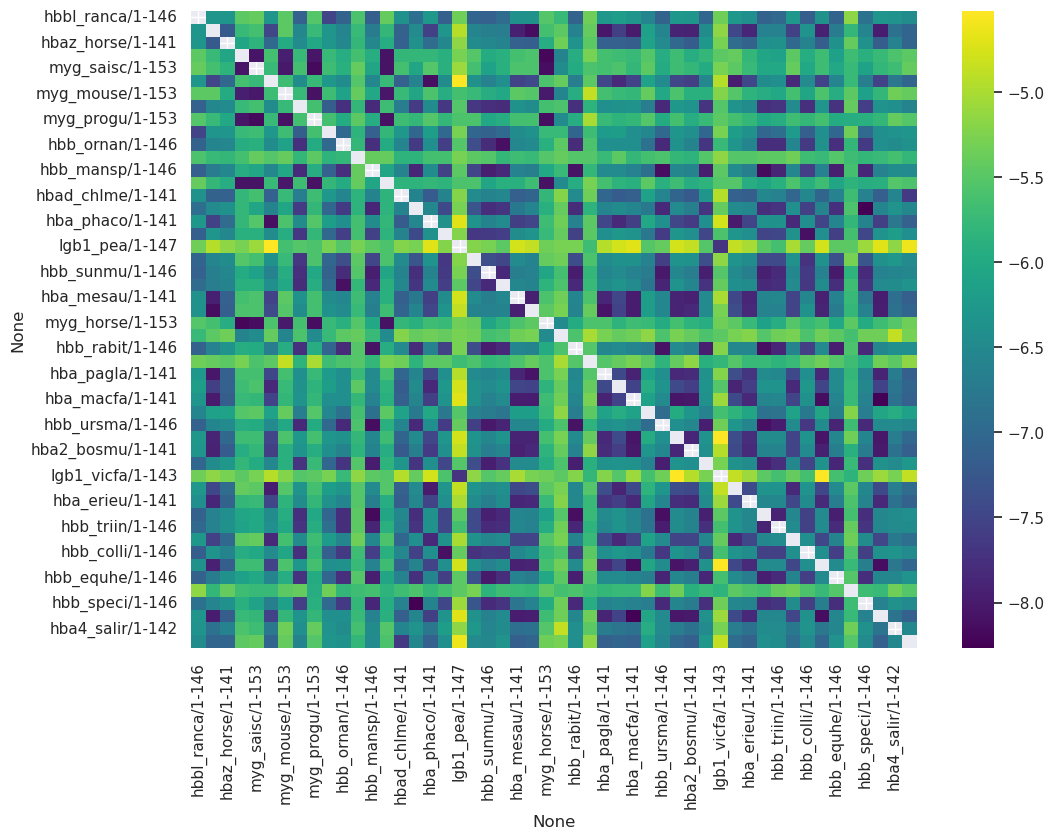

In [21]:
wpgma_matrix
pd.options.display.max_columns = None
pd.options.display.max_rows = None

wpgma_df = pd.DataFrame(wpgma_matrix, 
                      index=[names], 
                      columns=[names])

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Visualise the distance matrix of all sequences versus each other
# Use mask to hide the inf values on the diagonal so they don't break the color scale
sns.heatmap(wpgma_df, annot=False, cmap="viridis", mask=np.isinf(wpgma_df))



In [24]:
##
## Use this code block to run WPGMA, produce the tree and draw it, like we did earlier.
##
consensus=[]
[my_tree,consensus]=wpgma_cluster(wpgma_matrix.copy(),names.copy(),sequences.copy())

Merging Nodes: 15 and 46 Distance:-8.266627054524056 Branch Length:-4.1333
Merging Nodes: 30 and 46 Distance:-8.237743803890933 Branch Length:-4.1189
Merging Nodes: 3 and 24 Distance:-8.193621385267535 Branch Length:-4.0968
Merging Nodes: 4 and 8 Distance:-8.178694903738998 Branch Length:-4.0893
Merging Nodes: 11 and 37 Distance:-8.178694903738998 Branch Length:-4.0893
Merging Nodes: 1 and 22 Distance:-8.148503501470689 Branch Length:-4.0743
Merging Nodes: 27 and 39 Distance:-8.148503501470689 Branch Length:-4.0743
Merging Nodes: 11 and 29 Distance:-8.140869320531596 Branch Length:-4.0704
Merging Nodes: 5 and 15 Distance:-8.133235139592504 Branch Length:-4.0666
Merging Nodes: 9 and 19 Distance:-8.117849310313009 Branch Length:-4.0589
Merging Nodes: 15 and 35 Distance:-8.117849310313009 Branch Length:-4.0589
Merging Nodes: 3 and 4 Distance:-8.105767456879159 Branch Length:-4.0529
Merging Nodes: 10 and 20 Distance:-8.098347225126055 Branch Length:-4.0492
Merging Nodes: 3 and 11 Distance:

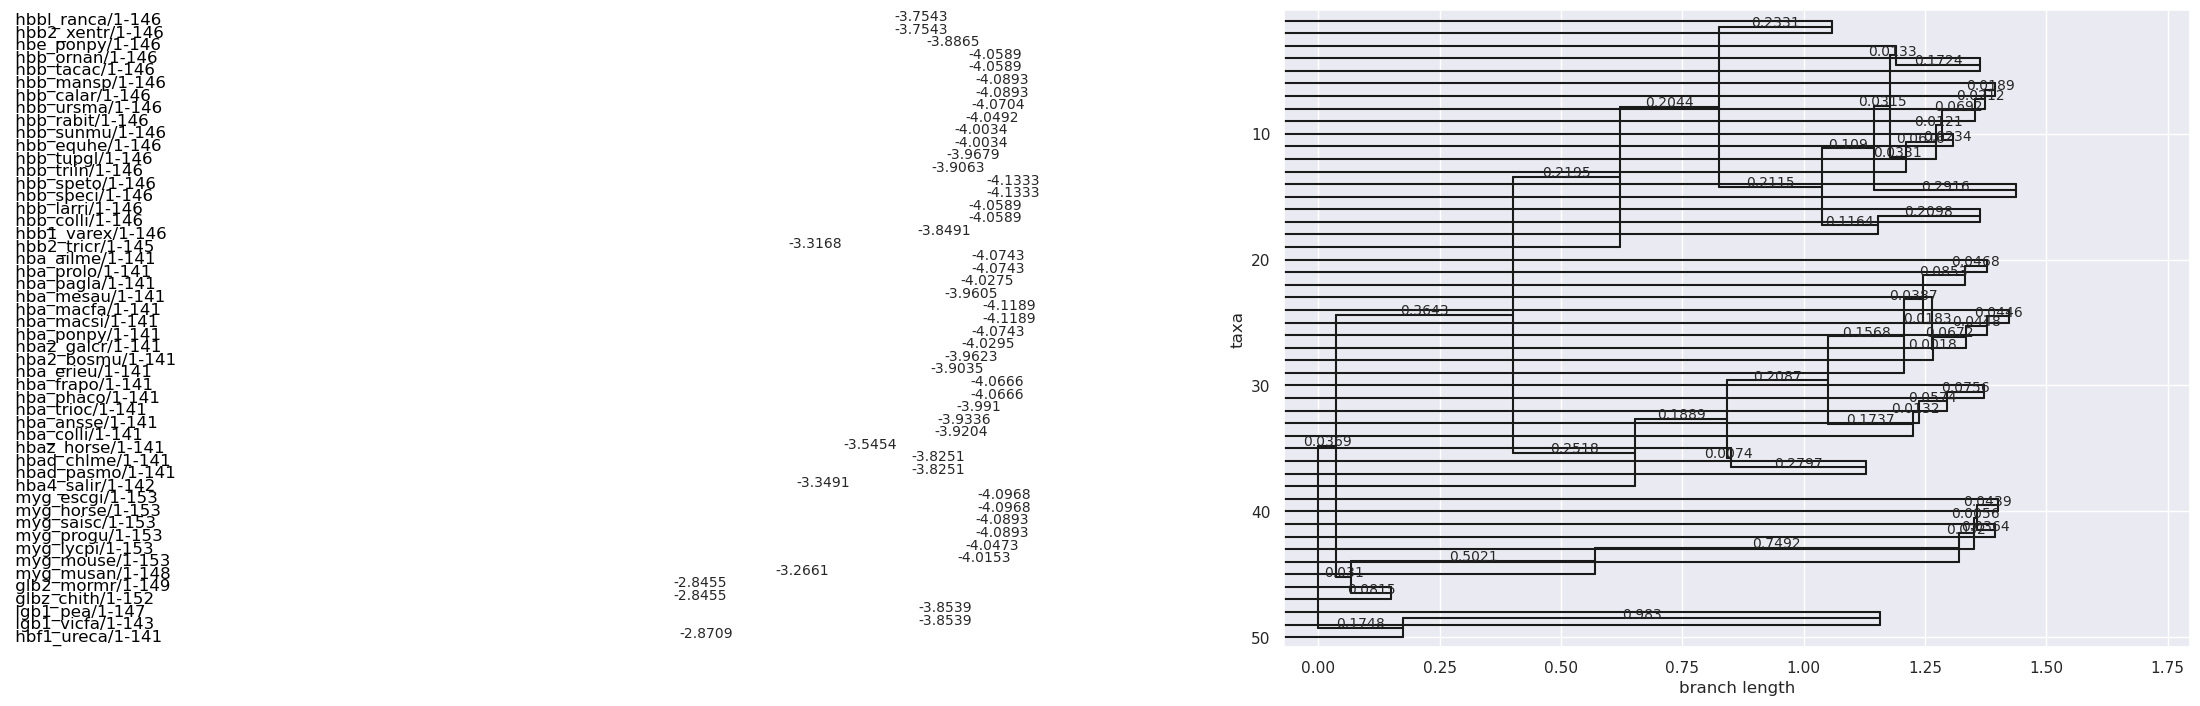

In [28]:
# This prefers reading from files, so we will make a fake filehandle using StringIO
handle = StringIO(my_tree[0])

# Load our tree from a string pretending to be a file
tree = Phylo.read(handle, "newick")

# Draw the tree with labels for branch lengths estimated from our WPGMA
Phylo.draw(tree,branch_labels=lambda c: c.branch_length)

In [29]:
## Finally use this code block to run the Natsciliner code from above on your new larger set of sequences
#
#

print("Multiple Sequence Alignment: MCB Natsciliner v(1.1B)")
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")

msa_matrix = np.chararray(shape=(len(consensus[0]), len(consensus)), unicode=True) 

for i in range(0,len(consensus[0])):
    print(orig_names[i]+":",end="\t")
    for j in range(0,len(consensus)):
        print(consensus[j][i],end="")
        msa_matrix[i][j]=str(consensus[j][i])
    print()

Multiple Sequence Alignment: MCB Natsciliner v(1.1B)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
hbbl_ranca/1-146:	VH----------WTAEEKAVINSVWQKV--DVEQD---GHEALTRLFIVYPWTQRYFSTFGDLS-SPAAIAGNPKVHAHGKKILGAIDNAIHNL---DDVK------GTLHDLSEEHANELHVDPENFRRLGEVLIVVLGAKLGKAFSPQVQHVWEKFIA--VLVDALSHSYH------
hba_ailme/1-141:	VH----------WTAEEKATIASVWGKV--DIEQD---GHDALSRLLVVYPWTQRYFSSFGNLS-NVSAVSGNVKVKAHGNKVLSAVGSAIQHL---DDVK------SHLKGLSKSHAEDLHVDPENFKRLADVLVIVLAAKLGSAFTPQVQAVWEKLNA--TLVAALSHGYF------
hbaz_horse/1-141:	VH----------FTAEEKAAVTSLWSKM--NVEEA---GGEALGRLLVVYPWTQRFFDSFGNLS-SPSAILGNPKVKAHGKKVLTSFGDAIKNM---DNLK------TTFAKLSELHCDKLHVDPENFKLLGNVMVIILATHFGKEFTPEVQAAWQKLVS--AVAIALAHKYH------
myg_escgi/1-153:	VH----------LSGGEKSAVTNLWGKV--NINEL---GGEALGRLLVVYPWTQRFFEAFGDLS-SAGAVMGNPKVKAHGAKVLTSFGDALKNL---DDLK------GTFAKLSELHCDKLHVDPENFNRLGNVLIVVLARHFSKDFSPEVQAAWQKLVS--GVAHALGHKYH------
myg_saisc/1-153:	VH----------LSGSEKTAVTNLWGHV--NVNEL---GGEALGRLLVVYPWTQRFFESFGDLS-SADAVMGNAKVKAHGAKVLTSF

/tmp/ipykernel_932/1264483045.py:8: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  msa_matrix = np.chararray(shape=(len(consensus[0]), len(consensus)), unicode=True)


# Analysis of Alignment Entropy/Consistency

Lets try and compute the column-wise entropy values so that we can measure how good the alignment is.

the formula you would use would be:

$H(X) = -\sum_{n=1}^{k} p(x_i)log_2(p(x_i))$

So for each **unique** symbol in an alignment column, e.g 'V' we compute its frequency in the column: $p(x_i)$ and multiply by $log_2(p(x_i))$.

As there are 20 Amino Acids we could normalise this entropy by subtracting the column entropy from:

$R_{i} = log_2(20)-H(X)$

As a general rule of thumb, $R_{i}$ values obtained that are above 2 are considered conserved in amino acid alignments. However, we have some very gappy columns, so the values may sometimes be misleading for columns with excessive gaps.

We've created a numpy character matrix for the alignment which is *msa_matrix*.

You can use this to pull the symbols from the MSA, e.g. the alignment **column 22** would be:


In [30]:
msa_matrix[:,22]

chararray(['S', 'S', 'S', 'N', 'N', 'T', 'A', 'G', 'A', 'G', 'A', 'G',
           'G', 'T', 'T', 'G', 'S', 'S', 'A', 'A', 'A', 'A', 'E', 'A',
           'D', 'T', 'A', 'A', 'T', 'G', 'G', 'T', 'T', 'A', 'S', 'Q',
           'Q', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'A', '-', '-',
           '-', '-'], dtype='<U1')

So to compute the total entropy for this column we can loop over all amino acids. See which are present in the column and then use shannons entropy to compute the entropy for this column. as below:

In [31]:
import matplotlib.pyplot as plt
nrows=msa_matrix.shape[0]
ncols=msa_matrix.shape[1]
total_entropy=0

for i in range(0,len(amino_acids)):
        symbol=amino_acids[i]                   #current amino acid
        occ=sum(msa_matrix[:,22].count(symbol))  #no of occurences of that symbol
        if (occ>0):                             # is it present in the column ?
            prob=occ/nrows                      #probability if present
            entropy=prob*math.log2(prob)        #Compute Shannon Entropy
            total_entropy-=entropy              #add that symbols entropy to our negative sum

print("Total Entropy, Col 22=",total_entropy)


Total Entropy, Col 22= 2.5311443006118695


# Task 2
______________
* The code block below extends the above to compute the entropy for each column and store them in a list or print them out.


Col:0 Entropy:1.1640460910694936
Col:1 Entropy:1.055000846777141
Col:2 Entropy:0.3564107451387086
Col:3 Entropy:0.5243856189774725
Col:4 Entropy:0.5243856189774725
Col:5 Entropy:0.46928786893420305
Col:6 Entropy:0.41150849518197796
Col:7 Entropy:0.41150849518197796
Col:8 Entropy:0.41150849518197796
Col:9 Entropy:0.40438561897747244
Col:10 Entropy:0.5243856189774725
Col:11 Entropy:1.0023326760571978
Col:12 Entropy:1.1361725257779403
Col:13 Entropy:0.9783666274010697
Col:14 Entropy:2.33935130280513
Col:15 Entropy:2.535987615467051
Col:16 Entropy:1.4308562983864117
Col:17 Entropy:1.0882127699741067
Col:18 Entropy:2.8923203642210837
Col:19 Entropy:2.5241831595884836
Col:20 Entropy:1.2317890110921692
Col:21 Entropy:2.7575583767180882
Col:22 Entropy:2.5311443006118695
Col:23 Entropy:2.2256319468766432
Col:24 Entropy:0.7026124091941206
Col:25 Entropy:1.7370908981924884
Col:26 Entropy:0.9372685007309205
Col:27 Entropy:1.262613191967389
Col:28 Entropy:1.7982925742645917
Col:29 Entropy:1.6543475

<BarContainer object of 179 artists>

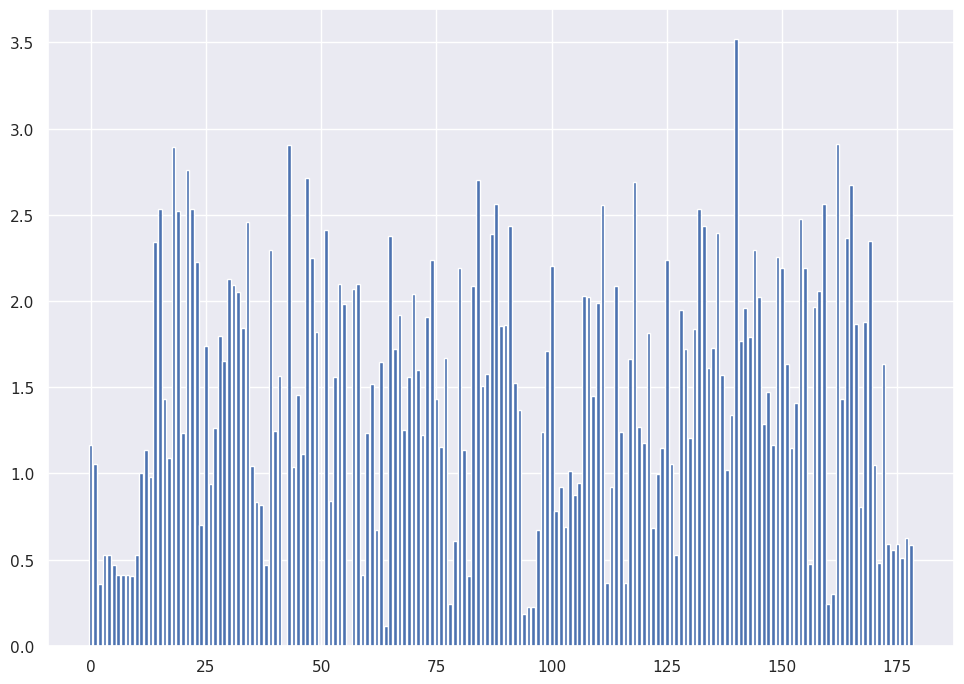

In [32]:
import matplotlib.pyplot as plt
nrows=msa_matrix.shape[0]
ncols=msa_matrix.shape[1]
total_entropy=0

entropies=[]
rel_entropies=[]

for j in range(0,ncols):
    total_entropy=0
    relative_entropy=0
    # iterate on all possible amino-acids that could occur in the column
    for i in range(0,len(amino_acids)):
        symbol=amino_acids[i]                   #current amino acid
        occ=sum(msa_matrix[:,j].count(symbol))  #no of occurences of that symbol
        if (occ>0):                             # is it present in the column ?
            prob=occ/nrows                      #probability if present
            entropy=prob*math.log2(prob)        #Compute Shannon Entropy
            total_entropy-=entropy              #add that symbols entropy to our negative sum
            
    entropies.append(total_entropy)
    print("Col:"+str(j)+" Entropy:"+str(total_entropy))

#  Entropy Bar Plot over all columns
plt.bar(range(0,ncols),entropies)

Modify the code above in the block below to improve it as follows:

1. Compute also *relative entropy* by taking your column entropy values a subtracting them from $log_2(20)$
2. Make a plot using matplotlib (barplot, e.g. **plt.bar()** as shown but for the relative entropies (i.e. column consistencies)

Col:0 Relative Entropy:18.32935053878284
Col:1 Relative Entropy:18.172654077692204
Col:2 Relative Entropy:8.174568320840521
Col:3 Relative Entropy:16.013186894003518
Col:4 Relative Entropy:16.013186894003518
Col:5 Relative Entropy:12.02720854679368
Col:6 Relative Entropy:12.142767294298132
Col:7 Relative Entropy:12.069890170502639
Col:8 Relative Entropy:12.142767294298132
Col:9 Relative Entropy:8.126593447001758
Col:10 Relative Entropy:15.940309770208021
Col:11 Relative Entropy:18.456203884367472
Col:12 Relative Entropy:22.529211142269613
Col:13 Relative Entropy:11.401462188689198
Col:14 Relative Entropy:22.880593578832524
Col:15 Relative Entropy:27.09507924936784
Col:16 Relative Entropy:16.107583909504683
Col:17 Relative Entropy:18.767714024293312
Col:18 Relative Entropy:27.03720330579323
Col:19 Relative Entropy:29.335960799333588
Col:20 Relative Entropy:14.008268714730225
Col:21 Relative Entropy:36.38583331501322
Col:22 Relative Entropy:23.131796024760984
Col:23 Relative Entropy:17.6

<BarContainer object of 179 artists>

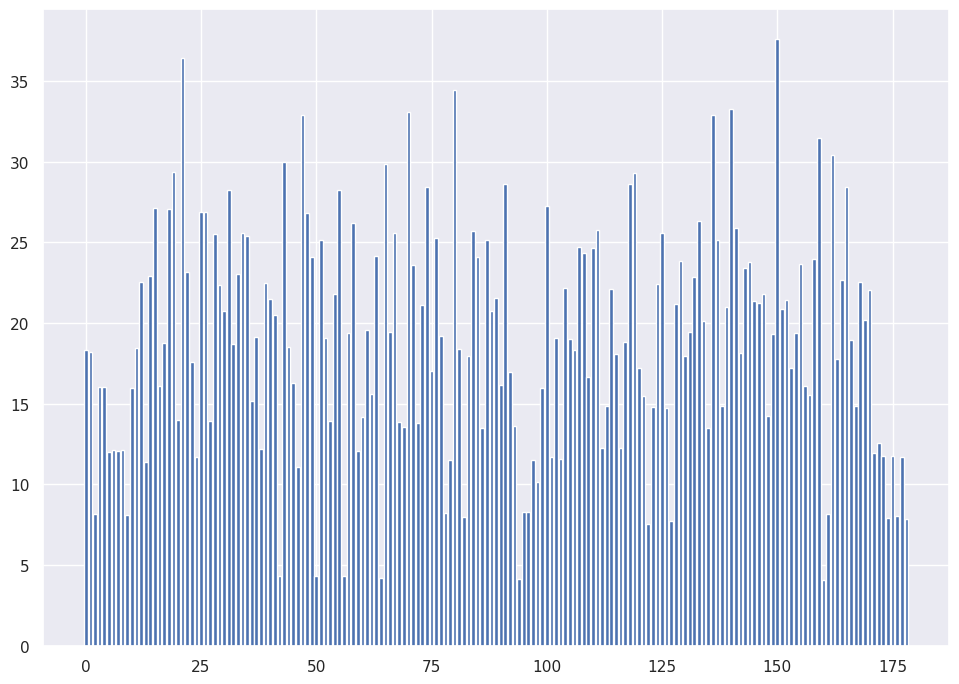

In [35]:
#
# 
#
total_entropy=0

entropies=[]
rel_entropies=[]

for j in range(0,ncols):
    total_entropy=0
    relative_entropy=0
    # iterate on all possible amino-acids that could occur in the column
    for i in range(0,len(amino_acids)):
        symbol=amino_acids[i]                   #current amino acid
        occ=sum(msa_matrix[:,j].count(symbol))  #no of occurences of that symbol
        if (occ>0):                             # is it present in the column ?
            prob=occ/nrows                      #probability if present
            entropy=prob*math.log2(prob)        #Compute Shannon Entropy
            total_entropy-=entropy               #add that symbols entropy to our negative sum
            relative_entropy+=math.log2(20)-total_entropy

    entropies.append(relative_entropy)
    print("Col:"+str(j)+" Relative Entropy:"+str(relative_entropy))

#  Entropy Bar Plot over all columns
plt.bar(range(0,ncols),entropies)

# Task 3 - Running MSA tools on the command-line

## Alignment using the MUSCLE algorithm

Lets use the **\!** to call a command-line terminal function. We will ask the pre-installed muscle algorithm to cluster the same FASTA file and we can compare results.

Musle just needs two options, an input file *-align XXXX* and an output file *-output. YYYYY*.

We will use the UNIX *cat* command to immediately print back the result.


In [38]:
!muscle -in data/L2/globin_small.fasta -out data/L2/globin_small.aln
!cat data/L2/globin_small.aln


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

globin_small 10 seqs, lengths min 37, max 41, avg 40
00:00:00    16 MB(-2%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-2%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    17 MB(-2%)  Iter   1  100.00%  Align node       
00:00:00    17 MB(-2%)  Iter   1  100.00%  Root alignment
00:00:00    17 MB(-2%)  Iter   2  100.00%  Refine tree   
00:00:00    17 MB(-2%)  Iter   2  100.00%  Root alignment
00:00:00    17 MB(-2%)  Iter   2  100.00%  Root alignment
00:00:00    17 MB(-2%)  Iter   3  100.00%  Refine biparts
00:00:00    17 MB(-2%)  Iter   4  100.00%  Refine biparts
00:00:00    17 MB(-2%)  Iter   5  100.00%  Refine biparts
>lgb1_pea
GFTDKQEALVNSS-SEFKQNLPGYSILFYTIVLEKAPAAKG
>lgb1_vicfa
GFTEKQEALVNSSSQLFKQNPSNYSVLFYTIILQKAPTAKA
>hba_ailme
VLSPADKTNVKATWDKIGGHAGEYGGEALERTFASFPTTKT
>myg_musan
----VDWEKVNSVW

## Alignment using CLUSTAL Omega

Lets do the same thing using the latest CLUSTAL Omega.

Again it's fairly simple to use and will output right back into the notebook.



In [42]:
!clustalo --in data/L2/globin_small.fasta --outfmt msf

!!AA_MULTIPLE_ALIGNMENT 1.0
 squid.msf  MSF: 57  Type: P  February 05, 2026 14:38  Check: 9789  ..

 Name: lgb1_pea    Len:     57  Check: 3904  Weight: -1.00
 Name: lgb1_vicfa  Len:     57  Check: 6958  Weight: -1.00
 Name: myg_escgi   Len:     57  Check: 3894  Weight: -1.00
 Name: myg_horse   Len:     57  Check: 4637  Weight: -1.00
 Name: myg_progu   Len:     57  Check: 4859  Weight: -1.00
 Name: myg_saisc   Len:     57  Check: 4754  Weight: -1.00
 Name: myg_lycpi   Len:     57  Check: 4718  Weight: -1.00
 Name: myg_mouse   Len:     57  Check: 4422  Weight: -1.00
 Name: myg_musan   Len:     57  Check: 6834  Weight: -1.00
 Name: hba_ailme   Len:     57  Check: 4809  Weight: -1.00

//

            1                                                   50
lgb1_pea    GFTDKQEALV NSS....... .........S .EFKQNLPGY SILFYTIVLE
lgb1_vicfa  GFTEKQEALV NSS....... .........S QLFKQNPSNY SVLFYTIILQ
myg_escgi   VLSDAEWQLV LNIWAKVEAD VAGHGQDILI RLFKGHPETL E~~~~~~~~~
myg_horse   GLSDGEWQQV LNVWGKVEAD IAG

_____

Take a look at the alignments and compare them, Do any look better ?



In [ ]:
## clustalo looks clearer!

# Task 4 - Homology Search
In  first section, you will perform a homology search using BLASTn online server and you will obtain (download) sequences similar to the one you used as a query. 

Obtain the fasta sequence for the human endoretrovirus LTR5_Hs from the Dfam database https://dfam.org/family/DF000000558/summary

We should see the DNA family page for the *LTR5_Hs* human transposon sequence.
```
Classification and Taxa help
Classification: Interspersed_Repeat; Transposable_Element; Class_I_Retrotransposition; Retrotransposon; Long_Terminal_Repeat_Element; Gypsy-ERV; Retroviridae; Orthoretrovirinae; ERV2-group ; ERV2

Taxa:
[...]
; Homo sapiens
```

You should see an tab to **download** 

We want to choose the *FASTA* option.

This should download a FASTA file to your computer. 

it should look something like this:

```
>DF0000558.4 LTR5_Hs
tgtggggaaaagcaagagagatcagattgttactgtgtctgtgtagaaagaagtagacat
aggagactccattttgttctgtactaagaaaaattcttctgccttgagattctgttaatc
tataaccttacccccaaccccgtgctctctgaaacatgtgctgtgtcaactcagggttaa
atggattaagggcggtgcaagatgtgctttgttaaacagatgcttgaaggcagcatgctc
cttaagagtcatcaccactccctaatctcaagtacccagggacacaaaaactgcggaagg
ccgcagggacctctgcctaggaaagccaggtattgtccaaggtttctccccatgtgatag
tctgaaatatggcctcgtgggaagggaaagacctgaccgtcccccagcccgacacccgta
aagggtctgtgctgaggaggattagtaaaagaggaaggaatgcctcttgcagttgagaca
agaggaaggcatctgtctcctgcccgtccctgggcaatggaatgtctcggtataaaaccc
gattgtatgttccatctactgagatagggaaaaaccgccttagggctggaggtgggacat
gcgggcagcaatactgctttgtaaagcattgagatgtttatgtgtatgcatatctaaaag
cacagcacttaatcctttaccttgtctatgatgcaaagacctttgttcacgtgtttgtct
gctgaccctctccccacnattgtcttgtgaccctgacacatccccctctccgagaaacac
ccacgaatgatcaataaatactaagggaactcagaggctggcgggatcctccatatgctg
aacgctggttccccgggtccccttatttctttctctatactttgtctctgtgtctttttc
ttttccaagtctctcgttccacctnacgagaaacacccacaggtgtggaggggcaaccca
ccccttca
```

Perhaps move it to your notebook folder.

### Next steps

We will use this sequence as a query in a blastn search.

The Sequence we have is an LTR type of transposable element from the human genome. They occur very frequently in our DNA and are ancient genetic parasites. We want to search the human genome to identify many instances of LTR elements and align them.

* Go to https://blast.ncbi.nlm.nih.gov/
* Select “Nucleotide blast” 


Enter the sequence of the **LTR5_Hs**, which you downloaded from the *Dfam* database, into the search box

We will change default parameters to limit your search to a restricted database and number results - we do this so we only retrieve a handful of hits from the human genome.

### First lets set up parameters
* Sequence: Paste in the FASTA sequence you downloaded or from above into the top search box
* Database:
  * ```RefSeq Genome Database (refseq_genomes)```
* Organism
  * Type in ```9606``` the organism code for human - select ```Home sapiens (taxid:9606)```
* Entrez Query
  * Type in the following: ```NC_000022[Accession] ```
* Program Selection
  * Select ```Somewhat similar sequences (blastn)``` ( you could try megablast and compare)

Now click on the Large **+** symbol and adjust the BLAST parameters

* Max Target sequences = 50

### Now click on BLAST button

Tick the box “Show results in a new window”, found next to the large blue “BLAST” button

Once the search is set up as shown in the figures, we are ready to start the reach. Click on the large BLAST button, and wait. A new window will pop open. The search should only take a few seconds but can take more depending on how busy the server is.

### Extracting a FASTA file of results

Wait till the BLAST is finished scroll down and click on:

* Alignments Tab
  * Then select Download, just underneath and choose
  * FASTA Aligned Sequences
  
### Next Steps

This should save a FASTA file with the sequences to your Desktop, theres also a copy in the notebook folder.
You should rename it to: ```ltr_hits.fasta```.

The *head* command in unix, shows you the first few lines of a file. It's useful to preview files. There's also a *tail* command to look at the end of the file.

Lets take a look at it with the UNIX ```head``` command using \!

In [44]:
!tail -20 data/L2/ltr_hits.fasta

>NC_000022.11:38808431-38808535 Homo sapiens chromosome 22, GRCh38.p14 Primary Assembly
CAGAGACCTTTGTTCACTTGTTTATCTGCTGACCTTCCCTCCACTATTGTCCCATGACCCTGCCAAATCCCCCTCTGTGA
GAAACACCCAAGAATTATCAATAAA
>NC_000022.11:40500410-40500514 Homo sapiens chromosome 22, GRCh38.p14 Primary Assembly
TTTATTGATAATTCTTGGGTGTTTCTCACAGAGGGGGATTTGGCAGGGTCATGGGACAATAGTGGAGGGAAGGTCAGCAG
ATAAACAAGTGAACAAAGGTCTCTG
>NC_000022.11:40538463-40538567 Homo sapiens chromosome 22, GRCh38.p14 Primary Assembly
CAGAGACCTTTGTTCACTTGTTTATCTGCTGACCTTCCCTCCACTATTGTCCCATGACCCTGCCAAATCCCCCTCTGTGA
GAAACACCCAAGAATTATCAATAAA
>NC_000022.11:42961345-42961449 Homo sapiens chromosome 22, GRCh38.p14 Primary Assembly
CAGAGACCTTTGTTCACTTGTTTATCTGTTGACCTTCCCTCCACTATTGTCCTATGACCCTGCCAAATCCCCCTCTGTGA
GAAACACCCAAGAATGATCAATTAA
>NC_000022.11:23537189-23537250 Homo sapiens chromosome 22, GRCh38.p14 Primary Assembly
AAGTCTCTCATTCCACCTGATGAGAAACACCCAGAGGTGTGGAGGGGCAGGCCACCCCTTCA
>NC_000022.11:42961302-42961347 Homo sapiens chromosome 22, GRCh38.p1

# Task 5 - Alignments in Jalview

## Launching JalView

Lets load up Jalview and explore our sequences and generate alignments for this large family of transposon related sequences that were scattered across Chromosome 22 of the Human Genome.

* Start up Jalview from the Desktop icon
* It may also launch by double clicking the FASTA file you downloaded (on some computers, e.g. mac)
* Once its loaded close any open alignments and choose
    * File -> Input Alignment -> From File
    * Select the type as -> FASTA
    * Now select the right folder and choose your FASTA file (should be ltr_hits.fasta
* Lets colour our alignment by nucleotide
    * Select -> Colour -> Nucleotide

This should be displaying a reasonable, but unaligned set of sequences identified via the inital BLAST search.

To produce a proper MSA we need to run it through a multiple sequence aligner. Luckily Jalview can connect to multiple web-services, such as at the EBI and run the alignments remotely.

Although you've seen above that we could also run either MUSCLE or Clustal Omega on the command-line, this is quite convenient.

### Running Alignments on our Sequences

* First go to:
    * Web-Service -> Alignment -> Choose one of:
        * **MAFFT (defaults)**
        * **MUSCLE (defaults)**
        * **T-Coffee (defaults)**
        * **Clustal O (defaults)**
    * You can generate a few different alignments this way and visually compare them side by side
    * Take note of how different they are
        * Which ones look better ?
        * How does the consensus sequence look ?
        * How long did they take to run ?
            * Rembember from our lectures that T-Coffee is likely slowest, with Clustal probably fastest.
            
### Alignment Analysis

You can use the *Analysis* menu to explore different clusterings (trees) from the alignments and also to perform PCA plots based on the aligned residues. 

For these sequences in a 3D PCA you should see 3 or 4 distinct clusters of sequences.


muscle has the least of consensus, clustalo & Mafft about the same, T-Coffe has the most of consensus (but also slowest)

# Task 6 - Protein Alignments

## Revisiting the Globin family

We will go back to the Globin family where we've been performing alignments already above.

Let's go to the masterdatabase **PFAM** that is a major source of curated and annotated protein domains including globin folds.

Go to: https://www.ebi.ac.uk/interpro/entry/pfam/PF00042/entry_alignments/

* Once there type ```globin``` in the *jump to* search box
    * From available alignments choose:
        * Seed (73) - We dont want ALL globins just the curated set they built the globin family with. 
    * Now choose Download
        * This should download: *PF00042.alignment.seed.gz*
    * Move the downloaded file to your Desktop or notebook folder and rename it to something like:
    
```globin_pfam_seed.fasta```


We can see what it looks like by peeking at it with the *head* command. As you can see it's alread hand aligned and curated by PFAM.
   

In [46]:
!head data/L2/globin_pfam_seed.fasta

>GLB2_LUMTE/31-141
QAIWRATFAQVPESRSLFKR.....VHGDDTSHPAFIAHAERVL.GG...LDIAISTLDQ
PATLK...EELDHLQVQHE...GRKIPD....NYFDAF.KTAILHVVAAQLG........
.RCYDREAWDACID.HIEDGI
>GLB2_TYLHE/32-143
IALWKSMFAQDNDARDLFKR.....VHGEDVHSPAFEAHMARVF.NG...LDRVISSLTD
EPVLN...AQLEHLRQQHI...KLGITG....HMFNLM.RTGLAYVLPAQLG........
.RCFDKEAWAACWDEVIYPGI
>GLB3_LAMSP/30-141
HFIWTHVFKDAPSARDLFKR.....VRGDNIHTPAFRAHATRVL.GG...LDMCIALLDD


### Back to Jalview for our Protein Alignment
Reopen *Jalview* and load in the Globin PFAM seed alignment.

Try out some of the different Colour schemes for Protein Sequences.

Explore some different alignments and see what you can come up with.

It's unlikely anything you produce will be *better* than this alignment as it's hand curation doesn't just optimise its visual consistency but took into account 3D structures and the biochemistry and knowledge of which particular amino-acids do.

There are also tools in Jalview for looking at disordered regions and protein secondary structure, so have a play with the interface to see what you can find.

You could of course go and explore some other protein families.

Please bear in mind that anything with large numbers of proteins (>200) may well be quite slow.

## Saving your Globin Seed Alignment as an MFA alignment
Export your final alignment by choosing:
* File -> Save As -> FASTA (MFA)
* Save the file as ```globin_seed.mfa```

As usual, lets drop to UNIX and take a peek from the command line:

In [47]:
! head -100 data/L2/globin_seed.mfa

>GLB2_LUMTE/31-141
QAIWRATFAQVPESRSLFKRVHG-DD-T----SHPAFIAHAER-VLGGLDIAISTL-DQ---PA---TLKE-
ELDHLQVQHEG---RK--IPD----NY-FDAFKTAILHVVAAQ----------LG-RC-YDREAWDACI-DH
-IE-DGI
>GLB2_TYLHE/32-143
IALWKSMFAQDNDARDLFKRVHG-ED-V----HSPAFEAHMAR-VFNGLDRVISSL-TD---EP---VLNA-
QLEHLRQQHIK---LG--ITG----HM-FNLMRTGLAYVLPAQ----------LG-RC-FDKEAWAACW-DE
VIY-PGI
>GLB3_LAMSP/30-141
HFIWTHVFKDAPSARDLFKRVRG-DN-I----HTPAFRAHATR-VLGGLDMCIALL-DD---EG---VLNT-
QLAHLASQHSS---RG--VSA----AQ-YDVVEHSVMMGVEHE----------IG-QNVFDKDAWQACL-DV
-IT-GGI
>GLB_TUBTU/29-139
LKLWNSIFRDAPEIRGLFKRVDG-DN-A----YSAEFEAHAER-VLGGLDMTISLL-DD---QA---AFDA-
QLAHLKSQHAE---RN--IKA----DY-YGVFVNELLAVLPDY----------LG-TK-LDFKAWSECL-GV
-IT-GAI
>GLB4_LUMTE/36-146
RAVFDDLFKHYPTSKALFERVKI-DE-P----ESGEFKSHLVR-VANGLDLLINLL-DD---TL---VLQS-
HLGHLADQHIQR--KG--VTK----EY-FRGIGEAFARVLPQV------L-S------CFNVDAWNRCF-HR
-LV-ARI
>GLB4_TYLHE/33-143
RLLFEELFEIDGATKGLFKRVNV-DD-T----HSPEEFAHVLR-VVNGLDTLIGVL-GD---SD---TLNS-
LIDHLAEQHKAR--AG--FKT----VY-FKEFGKALNHVLPEV-

________________________


# Part 2 - HMMs

We've covered a lot of the theory already. Now lets put it into practice.

First we need a simple way to encode a HMM Model, rememember the model has particular features, namely:

* States
* Emissions Probabilities (from some states)
* Transition Probabilities (from state to state)

We will encode this using a *class* type object in Python. I've specifically designed this for encoding our HMMs but you can adapt this as you need.

This class does nothing by itself, it simply provides a storage variable for the interlayered components of our HMM and the utility functions we need to build the model.



In [49]:
class hmm:
    
    def __init__(self):
        # General List to Store HMM states we will use.
        self.states = []
        # Empty Dictionaries to store transitions, emissions that will link to our states
        self.transitions = {}
        self.emissions = {}
        # This will allow us to add pseudocounts globally later
        self.pseudocounts = 0
        # This is a utility variable that records if our model has an end state we are using or not
        self.model_ends = 0

    # General utility function to add a state to a model.
    def add_states(self,stateslist):
        self.states=stateslist

    # General utility function to add a transition between two states we've added
    # Store raw probability - pseudocounts applied during normalise()
    def add_transitions(self,st1,st2,prob):
        self.transitions[st1,st2]=prob
        if ((st2 == 'end') & (prob > 0.0)):
            self.model_ends=1
            
    # General utility function to add emissions to specific states
    # Store raw emissions - pseudocounts applied during normalise()
    def add_emissions(self,st,ems):
        self.emissions[st]=ems.copy()

    # Allows us to tell the model to add a certain number of pseudocounts to all our values in the model
    def set_pseudocounts(self,pseudo):
        self.pseudocounts=pseudo

    # Simple function that can test if our model seems to be ok (i.e. do probabilities add to 1.0 etc)
    def check_hmm(self):
        # Check states to other state transitions sum to 1.0
        for st1 in self.states:
            sum=0
            for st2 in self.states:
                try:
                    sum=sum+self.transitions[st1,st2]
                except KeyError:
                    # If we didn't encode a transition set it to zero
                    self.add_transitions(st1,st2,0.0)
            print("State:",st1,"Transition sum:",sum)
            
        # Check states with emissions sum to 1.0
        for st in self.emissions:
            sum=0
            for em in self.emissions[st]:
                sum=sum+self.emissions[st][em];
            print("State",st,"Emissions sum:",sum)

    # This allows us to add pseudocounts, or to even build the model with pure counts and normalise 
    # everything back to probabilities
    
    def normalise(self):
        # Normalise provided transmission states to 1.0
        # Set any other possible transition state to 0.0
        for st1 in self.states:
            sum=0
            for st2 in self.states:
                try:
                    # Add pseudocounts before summing
                    self.transitions[st1,st2] = self.transitions[st1,st2] + self.pseudocounts
                    sum=sum+self.transitions[st1,st2]
                except KeyError:
                    # If we didn't encode a transition set it to zero, no pseudocounts viewed as impossible
                    self.transitions[st1,st2]=0.0
            if (sum != 0):
                for st2 in self.states:
                    self.transitions[st1,st2]=(self.transitions[st1,st2]/sum)
        # Normalise emission states sum to 1.0
        for st in self.emissions:
            sum=0
            for em in self.emissions[st]:
                # Add pseudocounts before summing
                self.emissions[st][em] = self.emissions[st][em] + self.pseudocounts
                sum=sum+self.emissions[st][em]
            if(sum != 0):
                for em in self.emissions[st]:
                    self.emissions[st][em]=self.emissions[st][em]/sum

## Using Our HMM Class to build a simple model

Lets now build a HMM to match what we saw in the lectures for our intron vs exon prediction based on nucleotide compositions in a test sequence.
![image.png](intron_model.png)

Clearly we need a few states:
* start
* exon
* intron

We also need:
* The states need to be connected using the probabilities in the model.
* The *start* and *exon* states need emission probabilities.

Lets create a new **HMM** using our *class* above to try this out.

In [50]:

# Make a new HMM from our hmm class and call it intron_exon_hmm
intron_exon_hmm=hmm()



This simply creates a new hmm object form our class above with no data.

We need to populate the model using the utility functions in the class.

# Adding States
First we need to add our states. We have to do this first as transitions and emissions need states.

In [51]:

intron_exon_hmm.add_states(['start','exon','intron','end'])


## Add the Transition Probabilities for the model above

In [52]:

intron_exon_hmm.add_transitions('start','exon',   1.00)
intron_exon_hmm.add_transitions('start','intron', 0.00)
intron_exon_hmm.add_transitions('exon','exon',    0.81)
intron_exon_hmm.add_transitions('exon','intron',  0.19)
intron_exon_hmm.add_transitions('intron','intron',0.87)
intron_exon_hmm.add_transitions('intron','exon',  0.13)


## Adding Emission Probabilities for two emitting states

In [53]:

intron_exon_hmm.add_emissions('exon',{'A':0.35, 'C':0.20, 'G':0.13, 'T':0.32})
intron_exon_hmm.add_emissions('intron',{'A':0.19, 'C':0.13, 'G':0.12, 'T':0.56})


As a sanity check, we can double check our state transitions and emissions sum to one.

In [54]:

intron_exon_hmm.check_hmm()


State: start Transition sum: 1.0
State: exon Transition sum: 1.0
State: intron Transition sum: 1.0
State: end Transition sum: 0
State exon Emissions sum: 1.0
State intron Emissions sum: 1.0


# The Viterbi Algorithm

Lets add Python code for the Dynamic Programming decoding algorithm for HMMs, i.e. the *viterbi* algorithm. We discussed how this works in the lectures.

In [57]:
def viterbi(hmm,sequence):

    # Utility function to find the maximum value quickly as we move through the matrix
    def get_max_val_ind(values):
        max_val = values[0]
        max_ind = 0
        for ind, val in enumerate(values):
            if val>max_val:
                max_val = val
                max_ind = ind
        return max_val, max_ind

    # A Traceback function to work out the correct series of predicted states from our final result.
    def traceback(states,FP):
        path = ['end'] # the last element of the path is the end state
        current = FP[-1][-1] # the current state is the one written in the last cell of the matrix
        for i in range(len(FP[0])-2,0,-1): # loops on the symbols
            path = [current] + path # appends the current state to the path
    
            # finds the index of the current state in the list of states and moves to the corresponing row of FP 
            current = FP[states.index(current)][i] 
        path = ['begin'] + path # the first element of the path is the begin state
        return ' '.join(path) # transforms the list into a string where elements are separated by spaces

    # Initialise the viterbi matrix F and also the traceback matrix FP
    F = initialize_matrix(len(hmm.states),len(sequence)+2)
    FP = initialize_matrix(len(hmm.states),len(sequence)+2,hmm.states[0])
    F[0][0] = 1

    # Now we start Dynamic Programming
    for i in range(1,len(hmm.states)-1):
        F[i][1] = hmm.transitions[(hmm.states[0],hmm.states[i])]*hmm.emissions[hmm.states[i]][sequence[0]]
    for j in range(2,len(sequence)+1):
        for i in range(1,len(hmm.states)-1):
            values = []
            for k in range(1,len(hmm.states)-1):
                values.append(F[k][j-1]*hmm.transitions[(hmm.states[k],hmm.states[i])]*
                              hmm.emissions[hmm.states[i]][sequence[j-1]])
                
            max_val, max_ind = get_max_val_ind(values)
            F[i][j] = max_val
            FP[i][j] = hmm.states[max_ind+1]
            #print_matrix(F,hmm.states,sequence)
    values = []

    # Check if our model has an end state to calculate, some models don't
    for k in range(1,len(hmm.states)-1):
        if (hmm.model_ends):
            values.append(F[k][len(sequence)]*hmm.transitions[(hmm.states[k],hmm.states[-1])])
        else:
            values.append(F[k][len(sequence)]*1.0)
                
    max_val, max_ind = get_max_val_ind(values)
    F[-1][-1] = max_val
    FP[-1][-1] = hmm.states[max_ind+1]
    
    return (F, max_val, traceback(hmm.states,FP))

## Some utility functions

We need some functions to do the following tasks later and make code elsewhere more readable.

1. Log transforming probabilities for eas of reading for both individual probabilities and also matrices:
   * *logtrans* and
   * *vectorlogtrans* this uses numpys vectorise utility to apply single functions over matrices and vectors
   * Both of these take one (or more) values and return: $log_e(x)$

2. A utility to print out our DP matrix
   * *print_matrix*
  
4. A simple function to create a matrix for viterbi, forward or backward algorithms:
   * *initialise_matrix*
  
Lets do that now:

In [58]:
import math

# Define a function to do a log transformation of a probability
def logtrans(x):
    if (x == 0):
        return(float('-inf'))
    else:
        #return math.log(x,math.exp(1))
        return math.log(x,math.exp(1))

# Vectorize the function, allows us to run this on a matrix and not just a single value
vectorlogtrans=np.vectorize(logtrans)

def print_matrix(matrix,hmm,sequence): 
    ddf = pd.DataFrame(vectorlogtrans(matrix), index=np.array(hmm.states), columns=np.array([char for char in "*"+sequence+"*"]))
    display(ddf.round(2))


# A function to create a matrix to represent viterbi, forward or backward computations
def initialize_matrix(dim1,dim2,value=0):
    F = []
    for i in range(0,dim1):
        F.append([])
        for j in range(0,dim2):
            F[i].append(value)
    return F


# Running our HMM

## Decoding our sequence CGGTTT against our model
We want to evaluate the sequence CGGTTT against the model we built above. Lets call that *sequence*.

Then we will call the *viterbi* function to find the maximum a posteriori probability and path given our sequence through the model we defined.

We will store the DP matrix

In [59]:
sequence = 'CGGTTT'

F,Prob,path=viterbi(intron_exon_hmm,sequence)

print("Probability: ",Prob, " Log Transformed: ",logtrans(Prob))
print("STATE PATH", path)

print_matrix(F,intron_exon_hmm,sequence)

Probability:  5.6007079287764004e-05  Log Transformed:  -9.790032459366007
STATE PATH begin exon exon exon intron intron intron end


,*,C,G,G,T,T,T,*
start,0.0,-inf,-inf,-inf,-inf,-inf,-inf,-inf
exon,-inf,-1.61,-3.86,-6.11,-7.46,-8.81,-10.16,-inf
intron,-inf,-inf,-5.39,-7.64,-8.35,-9.07,-9.79,-inf
end,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-9.79


# Task 7

Try your own sequence against the HMM, something nice and long with hopefully some islands rich in CG nucleotides, something like CGGCGCCCGCCGGCTTATTGTCATTATTTACT.

The code block above can be modified to do this.

You should also use the 
print_matrix(F,intron_exon_hmm.states,sequence)


In [61]:
#
# Use this code block for Task 7
# 

sequence = 'CGGCGCCCGCCGGCTTATTGTCATTATTTACT'

F,Prob,path=viterbi(intron_exon_hmm,sequence)

print("Probability: ",Prob, " Log Transformed: ",logtrans(Prob))
print("STATE PATH", path)

print_matrix(F,intron_exon_hmm,sequence)

Probability:  6.381707158807351e-23  Log Transformed:  -51.10602149754906
STATE PATH begin exon exon exon exon exon exon exon exon exon exon exon exon exon exon intron intron intron intron intron intron intron intron intron intron intron intron intron intron intron intron intron intron end


,*,C,G,G,C,G,C,C,C,G,C,C,G,G,C,T,T,A,T,T,G,T,C,A,T,T,A,T,T,T,A,C,T,*
start,0.0,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
exon,-inf,-1.61,-3.86,-6.11,-7.93,-10.18,-12.00,-13.82,-15.64,-17.89,-19.71,-21.53,-23.79,-26.04,-27.86,-29.21,-30.56,-31.82,-33.17,-34.52,-36.77,-38.12,-39.94,-41.20,-42.55,-43.90,-45.16,-46.51,-47.86,-48.87,-49.50,-51.32,-52.67,-inf
intron,-inf,-inf,-5.39,-7.64,-9.81,-11.71,-13.88,-15.70,-17.52,-19.42,-21.59,-23.41,-25.32,-27.57,-29.74,-30.10,-30.82,-32.62,-33.33,-34.05,-36.31,-37.03,-39.21,-41.01,-41.73,-42.45,-44.25,-44.97,-45.69,-46.41,-48.21,-50.39,-51.11,-inf
end,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-51.11


# Forward and Backward Algorithms

Here are the implementations for both forward and backward DP for our HMM in similar fashion to our viterbi, they can be run in a very similar way.

Neither needs a traceback function, we are more interested in their final values and perhaps using their matrix values to assess individual positions in the HMM for errors and noise.
                                                             

In [62]:
# The Forward Algorithm
def forward(hmm,sequence):
    F = initialize_matrix(len(hmm.states),len(sequence)+2)
    F[0][0] = 1
    for i in range(1,len(hmm.states)-1):
        F[i][1] = hmm.transitions[(hmm.states[0],hmm.states[i])]*hmm.emissions[hmm.states[i]][sequence[0]]
    for j in range(2,len(sequence)+1):
        for i in range(1,len(hmm.states)-1):
            p_sum = 0
            for k in range(1,len(hmm.states)-1):
                p_sum += F[k][j-1]*hmm.transitions[(hmm.states[k],hmm.states[i])]*hmm.emissions[hmm.states[i]][sequence[j-1]]
            F[i][j] = p_sum
            #print_matrix(F,hmm.states,sequence)
    p_sum = 0
    for k in range(1,len(hmm.states)-1):
        if(hmm.model_ends):
            p_sum += F[k][len(sequence)]*hmm.transitions[(hmm.states[k],hmm.states[-1])]
        else: 
            p_sum += F[k][len(sequence)]*1.0
    F[-1][-1] = p_sum
    return (F, p_sum)


# The Backward Algorithm
def backward(hmm,sequence):
    F = initialize_matrix(len(hmm.states),len(sequence)+2)
    F[-1][-1] = 1
    if hmm.model_ends:
        for i in range(1,len(hmm.states)-1):
            F[i][-2] = hmm.transitions[(hmm.states[i],hmm.states[-1])]
    else:
        for i in range(1,len(hmm.states)-1):
            F[i][-2] = 1.0
    for j in range(len(sequence)-1,0,-1): 
        for i in range(1,len(hmm.states)-1):
            p_sum = 0
            #print_matrix(F,hmm.states,sequence)
            for k in range(1,len(hmm.states)-1):
                p_sum += F[k][j+1]*hmm.transitions[(hmm.states[i],hmm.states[k])]*hmm.emissions[hmm.states[k]][sequence[j]]
            F[i][j] = p_sum
    p_sum = 0
    for k in range(1,len(hmm.states)-1):
        p_sum += F[k][1]*hmm.transitions[(hmm.states[0],hmm.states[k])]*hmm.emissions[hmm.states[k]][sequence[0]]
    F[0][0] = p_sum
    return (F,p_sum)


# Task 8

For the model you made above, run both the *forward* **and** *backward* algorithms and save their output matrices and probabilities.

Compared to the viterbi matrix above. It would be convenient to use the print_matrix utility to visualise the results.

Both should produce the same final Probability so use one of those to predict the Posterior Marginal Probability of your sequence and the model.

$$
P_{posterior\_marginal} = \frac{P_{viterbi}}{P_{forward}}
$$

In [65]:
#viterbi(hmm, sequence) -- (F, max_val, traceback(hmm.states,FP))
# Use the block here to complete Task 8
#
Ffor,Psumf = forward(intron_exon_hmm,sequence)
print_matrix(Ffor,intron_exon_hmm,sequence)
print(Psumf)

,*,C,G,G,C,G,C,C,C,G,C,C,G,G,C,T,T,A,T,T,G,T,C,A,T,T,A,T,T,T,A,C,T,*
start,0.0,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
exon,-inf,-1.61,-3.86,-6.08,-7.83,-10.02,-11.75,-13.49,-15.24,-17.42,-19.14,-20.88,-23.06,-25.21,-26.91,-28.17,-29.31,-30.23,-31.42,-32.47,-34.29,-35.33,-36.71,-37.74,-38.96,-40.06,-40.93,-42.10,-43.14,-44.05,-44.77,-46.36,-47.56,-inf
intron,-inf,-inf,-5.39,-6.95,-8.71,-10.55,-12.41,-14.24,-16.04,-17.90,-19.78,-21.61,-23.50,-25.47,-27.40,-27.81,-28.39,-30.11,-30.65,-31.27,-33.47,-34.10,-36.21,-37.89,-38.38,-38.99,-40.71,-41.27,-41.90,-42.56,-44.31,-46.36,-46.88,-inf
end,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-46.47


6.563136381534203e-21


In [66]:
Fback,Psumb = backward(intron_exon_hmm,sequence)
print_matrix(Fback,intron_exon_hmm,sequence)
print(Psumb)

,*,C,G,G,C,G,C,C,C,G,C,C,G,G,C,T,T,A,T,T,G,T,C,A,T,T,A,T,T,T,A,C,T,*
start,-46.47,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
exon,-inf,-44.86,-42.74,-40.59,-38.86,-36.70,-34.96,-33.22,-31.5,-29.37,-27.65,-25.97,-23.92,-21.88,-20.31,-19.42,-18.42,-17.37,-16.50,-15.51,-13.49,-12.41,-10.73,-9.67,-8.79,-7.79,-6.74,-5.87,-4.89,-3.77,-2.63,-1.01,0.0,-inf
intron,-inf,-45.26,-43.24,-41.25,-39.40,-37.43,-35.63,-33.79,-31.9,-29.88,-27.98,-26.01,-23.90,-21.78,-19.72,-19.05,-18.42,-16.76,-16.09,-15.45,-13.32,-12.71,-10.74,-9.08,-8.42,-7.78,-6.12,-5.45,-4.81,-4.22,-2.67,-0.64,0.0,-inf
end,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.0


6.563136381534199e-21


In [68]:
Pmarg = Prob/Psumb
Pmarg

0.009723563229255284

# Task 9 - Build your own HMM

I will give you the basic model representing what we see below in Python code.

![image.png](alignment_model.png)


## Task 9 - Part 1
I want you to improve the model by adding new Insert states (one for each match state) and all the appropriate new emissions and transitions. Clearly they have no data from our model so you can estimate them.
 
## Task 9 - Part 2
Explore adding pseudocounts to the model for transitions or emissions you dont know. the function:

`profile_hmm.set_pseudocounts(x)` 

will automatically add the pseudocount value `x` to any transition or emission you add.

If you use pseudocounts remember to normalise the model afterwards using:

`profile_hmm.normalise()`

Try different sequences with your improved model once you think its working after testing it.

We tested this model with the sequence `ACACATC` but please do try others.

In [ ]:
#
# Use this code block and the spare blocks to try Task 9 - Part 1
# 


In [ ]:
#
#
# 

In [ ]:
#
# Use this code block and the spare blocks to try Task 9 - Part 2
#



# Task 10 - Building a HMMer HMM profile and searching with it

Here I want you to see how to use **HMMER** [http://hmmer.org] to build real HMM models very accurately and quickly from alignments. Our python tests above should have given you a better understanding of whats involved and the ability and a coding framework to try and build your own HMMs for different tasks.

The command to turn our *MSF* multiple sequence seed alignment into a profile HMM model involves using the ```hmmbuild``` command, which is installed on your computer.

## Building a HMM with hmmbuild

Lets build a new Hidden Markov Model automatically from our previous multiple sequence alignment:
HMMER will assess the alignment and work out how many match, insert, delete states are needed and estimate priors usings dirichlet mixture models and the alignment itself. It is very fast

In [70]:
!hmmbuild data/L2/globin.hmm data/L2/globin_seed.mfa

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             data/L2/globin_seed.mfa
# output HMM file:                  data/L2/globin.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     globin_seed             73   151   119     6.38  0.590 

# CPU time: 0.02u 0.00s 00:00:00.02 Elapsed: 00:00:00.02


__________
## Contents of a HMMER hmm file

Lets take a look at the contents of the HMM model that's been built.

We no longer need to run ```hmmcalibrate``` like you saw in the lecture slides, HMMER v3 does that during the build step in a very rapid manner, so it's already improved its statistical estimates.

Here's the top of the globin HMM file from HMMER obtained by peeking at the first 21 lines using the head command (mac and linux).

In [72]:
!head -21 data/L2/globin.hmm


HMMER3/f [3.3.2 | Nov 2020]
NAME  globin_seed
LENG  119
ALPH  amino
RF    no
MM    no
CONS  yes
CS    no
MAP   yes
DATE  Thu Feb  5 15:55:19 2026
NSEQ  73
EFFN  6.384827
CKSUM 57942828
STATS LOCAL MSV       -9.7296  0.71366
STATS LOCAL VITERBI  -10.3646  0.71366
STATS LOCAL FORWARD   -3.8231  0.71366
HMM          A        C        D        E        F        G        H        I        K        L        M        N        P        Q        R        S        T        V        W        Y   
            m->m     m->i     m->d     i->m     i->i     d->m     d->d
  COMPO   2.34474  4.53893  2.93857  2.69038  2.88475  3.08316  3.23704  3.00386  2.55939  2.41336  3.69178  3.11248  3.56400  3.05041  3.07556  2.75188  2.88018  2.70600  4.54681  3.62537
          2.68618  4.42225  2.77519  2.73123  3.46354  2.40513  3.72494  3.29354  2.67741  2.69355  4.24690  2.90347  2.73739  3.18146  2.89801  2.37887  2.77519  2.98518  4.58477  3.61503
          0.00574  5.55958  6.28192  0.61958  0.77255  0.000


You should be able to spot the following information in this file:

1) Header Section up to the line starting with **HMM**

2) Theres now a small header with some information on symbol emissions
```
HMM          A        C        D        E        F        G        H        I        K        L        M        N        P        Q        R        S        T        V        W        Y   
            m->m     m->i     m->d     i->m     i->i     d->m     d->d
```

3) From here onwards the information comes in triplets

* Match emission line (Number of these and below depends on the input alignment)

```COMPO   2.34474  4.53893  2.93857  2.69038  2.88475  3.08316  3.23704  3.00386  2.55939  2.41336  3.69178  3.11248  3.56400  3.05041  3.07556  2.75188  2.88018  2.70600  4.54681  3.62537```
    
* Insert emission line 
    
```2.68618  4.42225  2.77519  2.73123  3.46354  2.40513  3.72494  3.29354  2.67741  2.69355  4.24690  2.90347  2.73739  3.18146  2.89801  2.37887  2.77519  2.98518  4.58477  3.61503```

* State transition line (7 of these)
```0.00574  5.55958  6.28192  0.61958  0.77255  0.00000        *```
    
* The state transitions correspond to: ```m->m     m->i     m->d     i->m     i->i     d->m     d->d```




## HMM Profile Search

We can now use the Hidden Markov Model built by HMMer to search against sequences to find those that are found to fit the model well according the DP forward-algorithms like *viterbi*

We just need to run ```hmmsearch``` and provide our recently created model and lets also provide the ```human.fasta``` file of 2700 human proteins we used in the last practical.


In [1]:
!hmmsearch data/L2/globin.hmm data/L1/human.fasta

# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# query HMM file:                  data/L2/globin.hmm
# target sequence database:        data/L1/human.fasta
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Query:       globin_seed  [M=119]
Scores for complete sequences (score includes all domains):
   --- full sequence ---   --- best 1 domain ---    -#dom-
    E-value  score  bias    E-value  score  bias    exp  N  Sequence                                                      Description
    ------- ------ -----    ------- ------ -----   ---- --  --------                                                      -----------
    1.1e-35  120.1   0.1    1.3e-35  119.9   0.1    1.1  1  ENSG00000130656|ENST00000252951|ENST0000025295

Try exploring the parameters of the search to allow more hits to come through. Options of interest could be found by running ```!hmmsearch -h``` in a code block.

Some critical options would be:

```
-E evalue (can adjust which hits pass filter)
--max (more sensitive)
--nobias (turn off low-complexity filter)
```

In [2]:
!hmmsearch -h

# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Usage: hmmsearch [options] <hmmfile> <seqdb>

Basic options:
  -h : show brief help on version and usage

Options directing output:
  -o <f>           : direct output to file <f>, not stdout
  -A <f>           : save multiple alignment of all hits to file <f>
  --tblout <f>     : save parseable table of per-sequence hits to file <f>
  --domtblout <f>  : save parseable table of per-domain hits to file <f>
  --pfamtblout <f> : save table of hits and domains to file, in Pfam format <f>
  --acc            : prefer accessions over names in output
  --noali          : don't output alignments, so output is smaller
  --notextw        : unlimit ASCII text output line width
  --textw <n>      : set max width of 

# Practical Complete